In [1]:
from COSIpy import *
import response
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import emcee
import time
import os
import fnmatch
plt.style.use('jacqueline')

Welcome to JupyROOT 6.24/06


/home/jacqueline/MEGAlib/external/root_v6.24.06/lib/ROOT/_facade.py:150: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  return _orig_ihook(name, *args, **kwds)


In [2]:
!python --version

Python 3.8.10


In [3]:
!which python

/home/jacqueline/.virtualenvs/python3-virt/bin/python


# Testing the point sources, 511 keV, and Al26 simulations, all with 10X flux
All of these simulations were made with the correct mass model (updated >= 220808)

## Load the data 

In [4]:
data_dir = '/volumes/eos/users/jacqueline/analysis/DataChallenge/DC1_Final/'


In [11]:
# All point sources, 511 keV, and 26Al. Each 10X flux. (no BG)
tra = 'all_sources.tra'


In [12]:
analysis1 = COSIpy(data_dir, tra)


In [13]:
analysis1.read_COSI_DataSet()


Switched to file /volumes/eos/users/jacqueline/analysis/DataChallenge/DC1_Final/GC511A_10xFlux.inc1.id1.extracted.tra.gz
Switched to file /volumes/eos/users/jacqueline/analysis/DataChallenge/DC1_Final/Al26_10xFlux.inc1.id1.extracted.tra.gz
Switched to file /volumes/eos/users/jacqueline/analysis/DataChallenge/DC1_Final/cenA_10xFlux.inc1.id1.extracted.tra.gz
Switched to file /volumes/eos/users/jacqueline/analysis/DataChallenge/DC1_Final/crab_10xFlux.inc1.id1.extracted.tra.gz
Switched to file /volumes/eos/users/jacqueline/analysis/DataChallenge/DC1_Final/cygX1_10xFlux.inc1.id1.extracted.tra.gz
Switched to file /volumes/eos/users/jacqueline/analysis/DataChallenge/DC1_Final/vela_10xFlux.inc1.id1.extracted.tra.gz


In [14]:
# define time bins

Delta_T = 1800 # s
analysis1.dataset.time_binning_tags(time_bin_size=Delta_T)


In [16]:
# definition of energy bins (exactly as response right now)

# for the continuum response:
energy_bin_edges = np.array([150, 220, 325, 480, 520, 765, 1120, 1650, 2350, 3450, 5000])

energy_bin_edges

array([ 150,  220,  325,  480,  520,  765, 1120, 1650, 2350, 3450, 5000])

In [17]:
# define energy and pixel binning

pixel_size = 6.

analysis1.dataset.init_binning(energy_bin_edges=energy_bin_edges, pixel_size=pixel_size)


In [18]:
# bin data
analysis1.dataset.get_binned_data()


In [19]:
#print([x for x in analysis1.dataset.times.times_cen])
print(analysis1.dataset.times.n_time_bins)
#print(analysis1.dataset.times.n_ph_t)
#print(analysis1.dataset.times.times_wid)
print(analysis1.dataset.times.total_time)

2241
4017566.5420205593


In [20]:
print("time, energy, phi, fisbel")

print(analysis1.dataset.binned_data.shape)


time, energy, phi, fisbel
(2232, 10, 30, 1145)


In [21]:
# summing over energy, phi and fisbel. Everything except the time axis
binned_counts = np.sum(analysis1.dataset.binned_data, axis=(1, 2, 3))

#print([int(x) for x in binned_counts])
print(np.sum([int(x) for x in binned_counts]))

152848


In [22]:
n_time_bins = analysis1.dataset.binned_data.shape[0]
print(n_time_bins)

2232


In [23]:
print('total', binned_counts.shape)

# binned_counts = np.sum(analysis1.dataset.binned_data, axis=(1, 2, 3))
plt.step(np.arange(n_time_bins), binned_counts,label='total', where='mid')

plt.xlabel(f'Time bin [DeltaT = {Delta_T} s]')
plt.legend();

total (2232,)


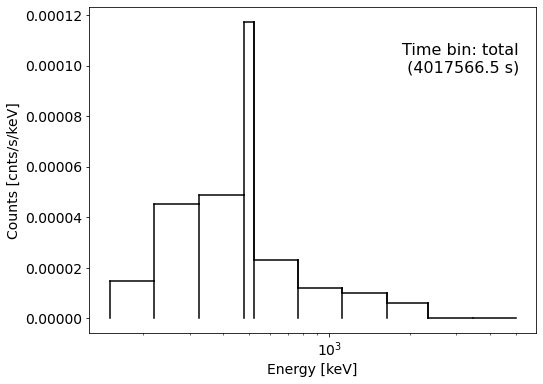

In [24]:
analysis1.dataset.plot_raw_spectrum()
plt.xscale('log')

In [25]:
# definition of poitings (balloon stability + Earth rotation)
pointing1 = Pointing(dataset=analysis1.dataset,)

In [26]:
# l1, b1 = 184.55746, -5.78436 # Crab


In [27]:
# plt.plot(pointing1.zpoins[:,0]+360, pointing1.zpoins[:,1], 'o')
# plt.plot(l1, b1,'*r',markersize=10)
# plt.xlabel('Longitude [deg]')
# plt.ylabel('Latitude [deg]')

In [28]:
# analysis1.horizon=60

In [29]:
# %matplotlib inline
# analysis1.plot_elevation([l1],[b1],['Galactic Center'])



############################
# for i in range(1728): # 86400/50=1748
#    # show Delta_T=50 time bins
#    plt.axvline(59200+i*Delta_T, linestyle='--', color='red')
    
# # plt.xlim(59000,62000)
# plt.xlim(59200,59800)
#plt.xlim(62800,63600)

# source rises and sets each day

# within each time bin, the source can move dramatically (steep change in elevation w/in certain bins)
#  before 59500, see steep change of ~15 deg --> this is our effectiv ang. res. at this DeltaT=50 time bin

# 60 deg in this plot is zenith
# w/in each time bin, we are smearing over source position --> no longer looks like a point. 
# we average over too many degrees

# extract mimrec data set between certain times for one day. e.g. 59200-59800
# black dots indicate when instrument is changing by 5 deg in any direction (hardcoded in cosipy)
# this is why there's a step like appearance --> can find optimal width of time bin. Maybe ~DeltaT=5 seconds
# for a smaller data set this might be fine

## BG model

In [30]:
# background

# # Al-26 response: 6 deg
# background1 = BG(dataset=analysis1.dataset,mode='sim 6deg despina')


# # ### use C. Karwin's Ling model BG simulation for the data challenge
background1 = BG(dataset=analysis1.dataset,
                mode='from file',
                filename=data_dir + 'Scaled_Ling_BG.inc1.id1.extracted.npz')

Using background mode: from file


## Save response file as .npz (if not already done)

In [31]:
### # Load the .rsp.gz file
### rsp_file = data_dir + 'response/511Response_cori_v1_nuclearizer_v8_9Det_imaging_atmos_5deg_v1.binnedimaging.imagingresponse.rsp.gz'
### test = response.SkyResponse(rsp_file, pixel_size=5, from_saved_file=False)
### test.ReadMEGAlibResponse()
### test.RebinToSquarePixelGrid(RegularPixelSize=5.)

### # Save as .npz
### test.SaveRegularBinnedMEGAlibResponse(data_dir + 'response/511Response_cori_v1_nuclearizer_v8_9Det_imaging_atmos_5deg_v1.binnedimaging.imagingresponse.npz')


## Reading in npz response file saved above (quite large, though)

In [32]:
# continuum response
rsp = response.SkyResponse(
    filename=data_dir + 'response/ContinuumResponse_cori_v1v2_nuclearizer_12Det_200812_imaging_atmos_9Det_6deg_10ebins.binnedimaging.imagingresponse.npz', pixel_size=6)



Reading complete continuum response. This might take a while...
Done.

Creating general RMF matrices, stay tuned...



Done.

Creating general IRF. Wait for it...
Done.

Deleting full matrix.
Done. Now have fun.


In [33]:
rsp.rsp.response_grid_normed_efinal.shape

(30, 60, 30, 1145, 10)

In [34]:
#rsp.plot_CDS_response(phi=10,psi=15,chi=90)

In [35]:
pixel_size

6.0

In [36]:
rsp.rsp.n_fisbel_bins

1145

In [37]:
np.shape(analysis1.dataset.binned_data)

(2232, 10, 30, 1145)

In [38]:
np.shape(background1.bg_model)

(2232, 10, 30, 1145)

In [39]:
cut = 90

In [40]:
# rsp.calculate_PS_response(analysis1.dataset,
#                           pointing1,l1,b1,1,
#                           cut=cut,
#                           background=background1,
#                           pixel_size=pixel_size,
#                           lookup=False)


In [42]:
ebin = 2 # 7 for continuum response, 0 for Al-26 keV response

In [43]:
# rsp.sky_response[ebin].shape

In [44]:
# plt.plot(analysis1.dataset.times.times_cen[analysis1.dataset.times.n_ph_dx],
#         np.sum(rsp.sky_response[ebin], axis=1),'o-')  

# plt.xlabel('Time [s]')
# plt.ylabel('Response [arbitrary units], \n normalized to one')
# #plt.text(x=2500, y=0.02, s=f'l1 = {l1}, b1 = {b1}',fontsize=14)

# # source rises and sets over individual days


In [45]:
# plt.plot(np.sum(analysis1.dataset.binned_data[:,ebin,:,:],axis=(1,2)),label='analysis1')  
# plt.plot(np.sum(background1.bg_model_reduced[ebin],axis=1),label='background1')
# plt.plot(np.sum(rsp.sky_response[ebin],axis=1)*1000,label='sky response')

# plt.legend()

In [46]:
from fit import *

# Follow COSIpy_RL_hardcoded notebook

In [47]:
# response dimensions
# lat x lon x phi x psi/chi x energy
rsp.rsp.response_grid_normed_efinal.shape

(30, 60, 30, 1145, 10)

<h3>Now comes the hard-coded part, where I haven't written tools yet, but some functions are available already:</h3>

In [48]:
from COSIpy_tools import get_image_response_from_pixelhit_hourly, zenaziGrid, one_func

<h3>Defining the sky to make images:</h3>

In [49]:
deg2rad = np.pi/180.

# we define our sky-grid on a regular 5x5 pixel grid for testing (later finer grid)
binsize = pixel_size#5. # 6. # 6. deg for continuum response, 5. deg for 511 keV response


# l and b pixel edges
l_arrg = np.linspace(-180,180,int(360/binsize)+1)
b_arrg = np.linspace(-90,90,int(180/binsize)+1)
# number of pixels in l and b
n_l = int(360/binsize)
n_b = int(180/binsize)
# making a grid
L_ARRg, B_ARRg = np.meshgrid(l_arrg,b_arrg)
# choosing the centre points as representative
l_arr = l_arrg[0:-1]+binsize/2
b_arr = b_arrg[0:-1]+binsize/2
L_ARR, B_ARR = np.meshgrid(l_arr,b_arr)

# define solid angle for each pixel for normalisations later
domega = (binsize*deg2rad)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2)))

<h3>Convert sky grid to zenith/azimuth pairs for all pointings:</h3>

In [50]:
# calculate the zeniths and azimuths on that grid for all times
# zensgrid,azisgrid = zenaziGrid(pointing1.xpoins[:,0],pointing1.xpoins[:,1],
#                                pointing1.ypoins[:,0],pointing1.ypoins[:,1],
#                                pointing1.zpoins[:,0],pointing1.zpoins[:,1],
#                                L_ARR.ravel(),B_ARR.ravel())

#### 4/20/22: cosipy is rotating the source position with the above lines? don't understand...the crab
# was in the right place...
zensgrid,azisgrid = zenaziGrid(pointing1.ypoins[:,0],pointing1.ypoins[:,1],
                               pointing1.xpoins[:,0],pointing1.xpoins[:,1],
                               pointing1.zpoins[:,0],pointing1.zpoins[:,1],
                               L_ARR.ravel(),B_ARR.ravel())

# reshape for next routines ... 
zensgrid = zensgrid.reshape(n_b,n_l,len(pointing1.xpoins))
azisgrid = azisgrid.reshape(n_b,n_l,len(pointing1.xpoins))

In [51]:
zensgrid.shape

(30, 60, 19563)

<h3>Getting the observation indices where we actually have measured photons (important for later):</h3>

In [52]:
nonzero_idx = background1.calc_this[ebin]

nonzero_idx.shape

(2295,)

<h3>Function to get the response of an image for arbitrary time binning:</h3>

In [53]:
def get_image_response_from_pixelhit_general(Response,zenith,azimuth,dt,n_hours,binsize=6,cut=60,altitude_correction=False,al=None):
    """
    Get Compton response from hit pixel for each zenith/azimuth vector(!) input.
    Binsize determines regular(!!!) sky coordinate grid in degrees.

    :param: zenith        Zenith positions of all points of predefined sky grid with
                          respect to the instrument (in deg)
    :param: azimuth       Azimuth positions of all points of predefined sky grid with
                          respect to the instrument (in deg)
    :option: binsize      Default 5 deg (matching the sky dimension of the response). If set
                          differently, make sure it matches the sky dimension as otherwise,
                          false results may be returned
    :option: cut          Threshold to cut the response calculation after a certain zenith angle.
                          Default 60
    :param: n_hours       Number of hours in cdxervation
    :option: altitude_correction Default False: use interpolated transmission probability, normalised to 33 km and 500 keV,
                          to modify number of expected photons as a function of altitude and zenith angle of cdxervation
    :option: al           Altitude values according to dt from construct_pointings(); used of altitude_correction is set to True
    """

    # assuming useful input:
    # azimuthal angle is periodic in the range [0,360[
    # zenith ranges from [0,180[

    # check which pixel (index) was hit on regular grid
    hit_pixel_zi = np.floor(zenith/binsize)
    hit_pixel_ai = np.floor(azimuth/binsize)

    # and which pixel centre
    hit_pixel_z = (hit_pixel_zi+0.5)*binsize
    hit_pixel_a = (hit_pixel_ai+0.5)*binsize

    # check which zeniths are beyond threshold
    bad_idx = np.where(hit_pixel_z > cut)

    # set hit pixels to output array
    za_idx = np.array([hit_pixel_zi,hit_pixel_ai]).astype(int)

    nz = zenith.shape[2]

    n_lon = int(360/binsize)
    n_lat = int(180/binsize)
    
    l_arrg = np.linspace(-180,180,int(360/binsize)+1)
    b_arrg = np.linspace(-90,90,int(180/binsize)+1)
    L_ARRg, B_ARRg = np.meshgrid(l_arrg,b_arrg)
    l_arr = l_arrg[0:-1]+binsize/2
    b_arr = b_arrg[0:-1]+binsize/2
    L_ARR, B_ARR = np.meshgrid(l_arr,b_arr)

    # take care of regular grid by applying weighting with latitude
    #weights = ((binsize*np.pi/180)**2*np.cos(np.deg2rad(B_ARR))).repeat(nz).reshape(n_lat,n_lon,nz)
    weights = ((binsize*np.pi/180)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2)))).repeat(nz).reshape(n_lat,n_lon,nz)
    weights[bad_idx] = 0

    
    # check for negative weights and indices and remove
    weights[za_idx[0,:] < 0] = 0.
    weights[za_idx[1,:] < 0] = 0.
    za_idx[0,za_idx[0,:] < 0] = 0.
    za_idx[1,za_idx[1,:] < 0] = 0.
        
    
    if altitude_correction == True:
        altitude_response = return_altitude_response()
    else:
        altitude_response = one_func

    # get responses at pixels
   
    #print('weights',weights.shape)
    #print('response',Response.shape)
    #print('dt',dt.shape)
    
    image_response = np.zeros((n_hours,n_lat,n_lon,Response.shape[2]))

    for c in tqdm(range(n_hours)):
        cdx = np.where((pointing1.cdtpoins > analysis1.dataset.times.times_min[analysis1.dataset.times.n_ph_dx[c]]) &
                       (pointing1.cdtpoins <= analysis1.dataset.times.times_max[analysis1.dataset.times.n_ph_dx[c]]))[0]

        #print('in loop response',Response[za_idx[0,:,:,cdx],za_idx[1,:,:,cdx],:])
        #print('in loop weights',weights[:,:,cdx,None].shape)
        #print('in loop weights switched', np.einsum('klij->iklj', weights[:,:,cdx,None]))
    
        # this calculation is basically a look-up of the response entries. In general, weighting (integration) with the true shape can be introduced, however with a lot more computation time (Simpson's rule in 2D ...)
        #altitude_weights = altitude_response(zenith[:,:,cdx].ravel(),al[cdx])[np.argsort(np.argsort(zenith[:,:,cdx].ravel()))].reshape(n_lat,n_lon)
        image_response[c,:,:,:] += np.sum(Response[za_idx[0,:,:,cdx],za_idx[1,:,:,cdx],:]*np.einsum('klij->iklj', weights[:,:,cdx,None])*dt[cdx,None,None,None],axis=0)#*altitude_weights[:,:,None]
        
    return image_response


<h1>Selection of the energy bin to make an image of. The response will be restricted to this one energy bin:</h1>

<h2>Here, we only have 1 energy bin</h2>

In [54]:
sky_response_CDS = rsp.rsp.response_grid_normed_efinal.reshape(
    n_b,
    n_l,
    analysis1.dataset.phis.n_phi_bins*\
    analysis1.dataset.fisbels.n_fisbel_bins, np.shape(analysis1.dataset.binned_data)[1])[:, :, nonzero_idx, ebin]





# # for Al-26 keV response: need index "1" for only 1 energy bin
# sky_response_CDS = rsp.rsp.response_grid_normed_efinal.reshape(
#     n_b,
#     n_l,
#     analysis1.dataset.phis.n_phi_bins*\
#     analysis1.dataset.fisbels.n_fisbel_bins, 1)[:, :, nonzero_idx, ebin]

In [55]:
# reduced response dimensions:
# lat x lon x CDS
sky_response_CDS.shape

(30, 60, 2295)

<h1>Calculation of the general response for the current data set.<br>
    This has to be done only once (for the data set).<br>
    Might take a few minutes.</h1>

In [56]:
analysis1.dataset.times.n_ph

2232

In [57]:
cut

90

In [58]:
sky_response_scaled = get_image_response_from_pixelhit_general(
    Response=sky_response_CDS,
    zenith=zensgrid,
    azimuth=azisgrid,
    dt=pointing1.dtpoins,
    n_hours=analysis1.dataset.times.n_ph,
    binsize=pixel_size, 
    cut=cut,
    altitude_correction=False,
    al=np.ones(len(pointing1.dtpoins)))

In [59]:
# data-set-specific response dimensions
# times x lat x lon x CDS
sky_response_scaled.shape

(2232, 30, 60, 2295)

<h3>Saving that data-set-specific response for later use:</h3>

In [60]:
# import h5py

In [61]:
# f = data_dir + 'UpdatedRegularResponseGrid_Continuum_3bins_v1_April_2022.h5'

# with h5py.File(f, 'w') as hf:
#     hf.create_dataset("response_continuum",  data=sky_response_scaled)

<h3>Calculation of the 'exposure map', i.e. the response weighted by time:</h3>

In [62]:
expo_map = np.zeros((n_b,n_l))

for i in tqdm(range(sky_response_scaled.shape[0])):
    expo_map += np.sum(sky_response_scaled[i,:,:,:], axis=2)

<h3>Plotting the exposure map weighted with the pixel size:</h3>

In [63]:
plt.subplot(projection='aitoff')
p = plt.pcolormesh(L_ARRg*deg2rad,B_ARRg*deg2rad,np.roll(expo_map/domega,axis=1,shift=0))
plt.contour(L_ARR*deg2rad,B_ARR*deg2rad,np.roll(expo_map/domega,axis=1,shift=0),colors='black')
plt.colorbar(p, orientation='horizontal')

In [64]:
expo_map.shape

(30, 60)

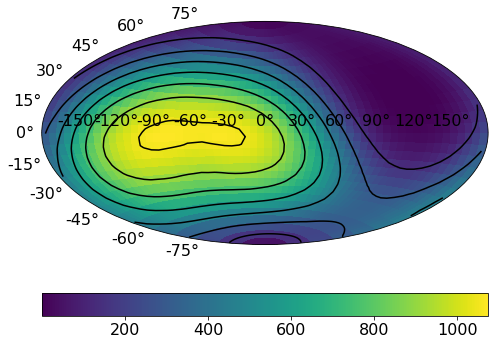

In [65]:
# remove the domega
plt.subplot(projection='aitoff')
p = plt.pcolormesh(L_ARRg*deg2rad,B_ARRg*deg2rad,np.roll(expo_map,axis=1,shift=0))
plt.contour(L_ARR*deg2rad,B_ARR*deg2rad,np.roll(expo_map,axis=1,shift=0),colors='black')
cbar = plt.colorbar(p, orientation='horizontal')

In [66]:

# multiply by domega. this is the effective area...supposedly? trying to figure out 
#  what exactly the units in cosipy are...

plt.subplot(projection='aitoff')
p = plt.pcolormesh(L_ARRg*deg2rad, B_ARRg*deg2rad, np.roll(expo_map*domega,axis=1,shift=0))
plt.contour(L_ARR*deg2rad, B_ARR*deg2rad, np.roll(expo_map*domega,axis=1,shift=0),colors='black')
cbar = plt.colorbar(p, orientation='horizontal')

<h1>Begin Richardson-Lucy here:</h1>

<h3>Define regions of the sky that we actually cannot see:</h3>

In [67]:
# here I select everything, i.e. we have no bad exposure

bad_expo = np.where(expo_map/domega <= 0)

<h3>Define function for a starting map fo the RL deconvolution. I choose an isotropic map, i.e. everything gets the same value:</h3>

In [68]:
def IsoMap(ll,bb,A0,binsize=6):
    shape = np.ones(ll.shape)
    norm = np.sum(shape*(binsize*np.pi/180)*(np.sin(np.deg2rad(bb+binsize/2)) - np.sin(np.deg2rad(bb-binsize/2))))
    val = A0*shape/norm
    return val

<h3>Number of time bins (should be the first dimension of the response; change accordingly):</h3>

In [69]:
d2h = n_time_bins 
d2h

2232

In [70]:
from COSIpy_tools import cashstat

<h3>Select only one energy bin (as above) for data set:</h3>

In [71]:
print('ebin: ',ebin)

# continuum response
# dataset = analysis1.dataset.binned_data[:,ebin,:,:].reshape(d2h,30*1145)[:,nonzero_idx]


dataset = analysis1.dataset.binned_data[:,ebin,:,:].reshape(
    d2h, analysis1.dataset.binned_data.shape[2]*analysis1.dataset.binned_data.shape[3])[:,nonzero_idx]

ebin:  2


<h3>Same for background:</h3>

In [72]:
background_model = background1.bg_model_reduced[ebin]

<h3>Check for consistency of data and background:</h3>

In [73]:
dataset.shape,background_model.shape

((2232, 2295), (2232, 2295))

<h3>Must have the same dimensions. If not, it won't work</h3>

<h3>Define background model cuts, indices, and resulting number of cuts:</h3>

In [74]:
bg_cuts, idx_arr, Ncuts = background1.bg_cuts, background1.idx_arr, background1.Ncuts

<h3>For my modified RL algorithm to work we need to load a stan model that fits background plus two images (the current image plus a delta image given by the RL formalism):</h3>

In [75]:
import pickle
import pywt
import pystan

In [76]:
#read filename.pkl (if already compiled)
# this might not work for you, let me know if there is a problem here

try:
    #read COSImodefit.pkl (if already compiled)
    #model_multimap = pickle.load(open('fit_COSI_conved_2D_new2_multimap_indivBG.pkl', 'rb'))
    model_multimap = pickle.load(open('fit_COSI_conved_2D_multimap_indivBG.pkl', 'rb'))

except:
    print('Model not yet compiled, doing that now (might take a while).')
    ## compile model (if not yet compiled):
    model_multimap = pystan.StanModel('fit_COSI_conved_2D_multimap_indivBG.stan')

    # for continuum response
    with open(data_dir + 'fit_COSI_conved_2D_multimap_indivBG_continuum_rsp_ebin2.pkl', 'wb') as f:
        pickle.dump(model_multimap, f)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f2390c79fba64c04b17c25d7ffa1173f NOW.


Model not yet compiled, doing that now (might take a while).


In file included from /home/jacqueline/.virtualenvs/python3-virt/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1822,
                 from /home/jacqueline/.virtualenvs/python3-virt/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/jacqueline/.virtualenvs/python3-virt/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/pystan_oki7xt2i/stanfit4anon_model_f2390c79fba64c04b17c25d7ffa1173f_6489844674276551831.cpp:696:
/home/jacqueline/.virtualenvs/python3-virt/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
In file included from /home/jacqueline/.virtualenvs/python3-virt/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/

## Read in 1 deg DIRBE file as a fits file, rebin to 6 deg x 6 deg, and plot it over the iterations below

In [77]:
def bin_ndarray(ndarray, new_shape, operation="sum"):
    """
    Bins an ndarray in all axes based on the target shape, by summing or
        averaging.
    Number of output dimensions must match number of input dimensions.
    Example
    -------
    >>> m = np.arange(0,100,1).reshape((10,10))
    >>> n = bin_ndarray(m, new_shape=(5,5), operation=‘sum’)
    >>> print(n)
    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]
    """
    if not operation.lower() in ['sum', 'mean', 'average', 'avg']:
        raise ValueError("Operation {} not supported.".format(operation))
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d, c in zip(new_shape,
                                                   ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        if operation.lower() == "sum":
            ndarray = ndarray.sum(-1*(i+1))
        elif operation.lower() in ["mean", "average", "avg"]:
            ndarray = ndarray.mean(-1*(i+1))
    return ndarray

In [78]:
from astropy.io import fits

In [79]:
dirbe_1deg = fits.open('/home/jacqueline/MEGAlib/resource/examples/advanced/AllSky/SPI_DIRBE_Orig_Knoedl_240um.fits')
data = dirbe_1deg[2].data

# interpolate to (360, 720)
from scipy.ndimage.interpolation import map_coordinates
new_dims = []
for original_length, new_length in zip(data.shape, (360, 720)):
    new_dims.append(np.linspace(0, original_length-1, new_length))
    
coords = np.meshgrid(*new_dims, indexing='ij')
B = map_coordinates(data, coords)
B.shape

dirbe_6deg_6deg = bin_ndarray(B, (30, 60), 'mean')
dirbe_6deg_6deg = np.flip(dirbe_6deg_6deg)

### If source+BG:
Use the comparison of source+Ling (analysis1) to Ling as starting guess for the bg params in the RL iterations

### If analyzing source only:
Used fitted_bg = np.array([1E-6])

In [80]:
fitted_bg = np.array([1E-6])

fitted_bg

array([1.e-06])

<h1>Richardson-Lucy algorithm (individual steps explained in code):</h1>

In [81]:
from scipy.ndimage import gaussian_filter

Convolving with response (init expectation), iteration 0


Calculating Delta image, iteration 1, numerator


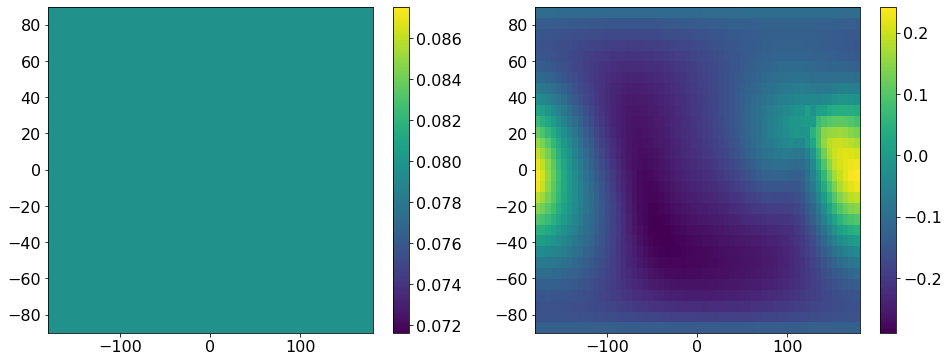

Convolving Delta image, iteration 1



Finding maximum acceleration parameter, iteration 1
Maximum acceleration parameter found:  0.275
Fitting delta-map in addition to old map, iteration 1
Saving new map, and fitted parameters, iteration 1
Calculating Delta image, iteration 2, numerator


Convolving Delta image, iteration 2



Finding maximum acceleration parameter, iteration 2
Maximum acceleration parameter found:  0.885
Fitting delta-map in addition to old map, iteration 2
Saving new map, and fitted parameters, iteration 2
Calculating Delta image, iteration 3, numerator


Convolving Delta image, iteration 3



Finding maximum acceleration parameter, iteration 3
Maximum acceleration parameter found:  0.345
Fitting delta-map in addition to old map, iteration 3
Saving new map, and fitted parameters, iteration 3
Calculating Delta image, iteration 4, numerator


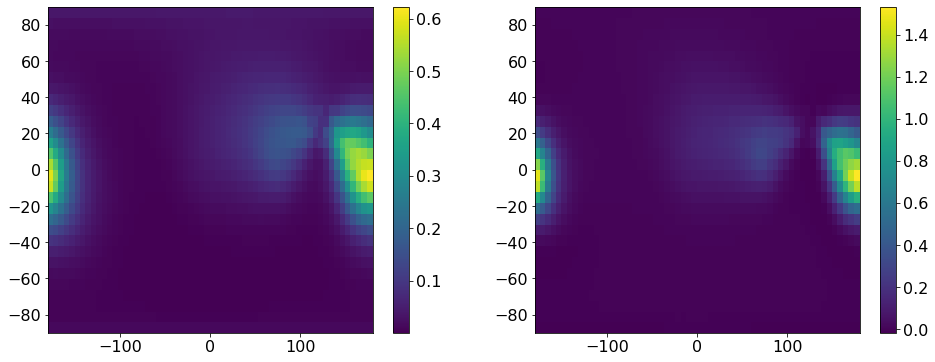

Convolving Delta image, iteration 4



Finding maximum acceleration parameter, iteration 4
Maximum acceleration parameter found:  0.716
Fitting delta-map in addition to old map, iteration 4
Saving new map, and fitted parameters, iteration 4
Calculating Delta image, iteration 5, numerator


Convolving Delta image, iteration 5



Finding maximum acceleration parameter, iteration 5
Maximum acceleration parameter found:  0.4
Fitting delta-map in addition to old map, iteration 5
Saving new map, and fitted parameters, iteration 5
Calculating Delta image, iteration 6, numerator


Convolving Delta image, iteration 6



Finding maximum acceleration parameter, iteration 6
Maximum acceleration parameter found:  0.619
Fitting delta-map in addition to old map, iteration 6
Saving new map, and fitted parameters, iteration 6
Calculating Delta image, iteration 7, numerator


Convolving Delta image, iteration 7



Finding maximum acceleration parameter, iteration 7
Maximum acceleration parameter found:  0.441
Fitting delta-map in addition to old map, iteration 7
Saving new map, and fitted parameters, iteration 7
Calculating Delta image, iteration 8, numerator


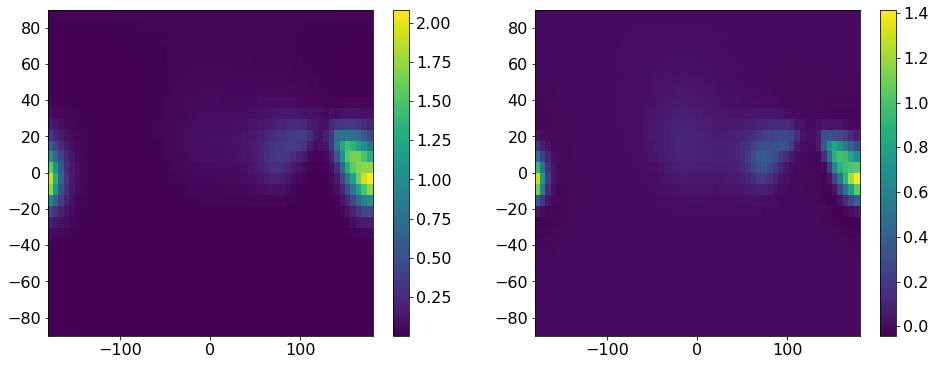

Convolving Delta image, iteration 8



Finding maximum acceleration parameter, iteration 8
Maximum acceleration parameter found:  0.593
Fitting delta-map in addition to old map, iteration 8
Saving new map, and fitted parameters, iteration 8
Calculating Delta image, iteration 9, numerator


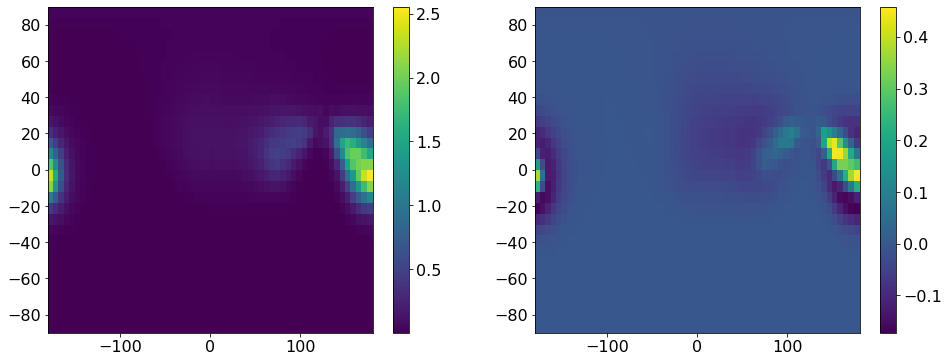

Convolving Delta image, iteration 9



Finding maximum acceleration parameter, iteration 9
Maximum acceleration parameter found:  0.483
Fitting delta-map in addition to old map, iteration 9
Saving new map, and fitted parameters, iteration 9
Calculating Delta image, iteration 10, numerator


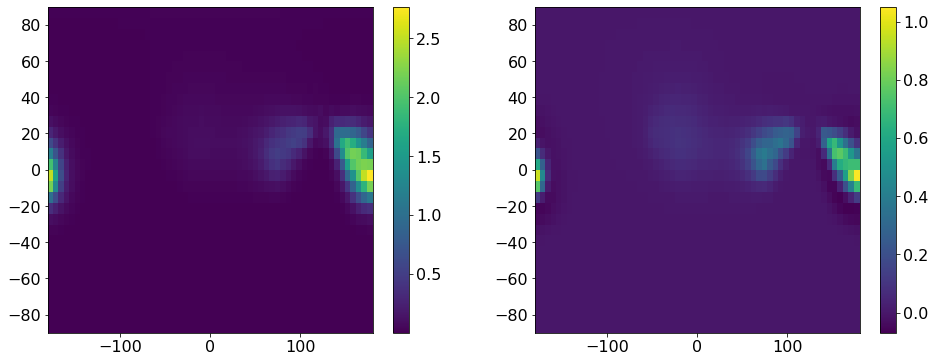

Convolving Delta image, iteration 10



Finding maximum acceleration parameter, iteration 10
Maximum acceleration parameter found:  0.56
Fitting delta-map in addition to old map, iteration 10
Saving new map, and fitted parameters, iteration 10
Calculating Delta image, iteration 11, numerator


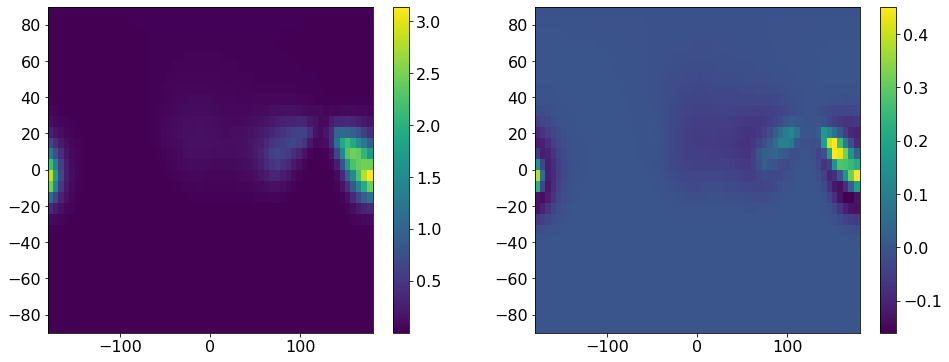

Convolving Delta image, iteration 11



Finding maximum acceleration parameter, iteration 11
Maximum acceleration parameter found:  0.493
Fitting delta-map in addition to old map, iteration 11
Saving new map, and fitted parameters, iteration 11
Calculating Delta image, iteration 12, numerator


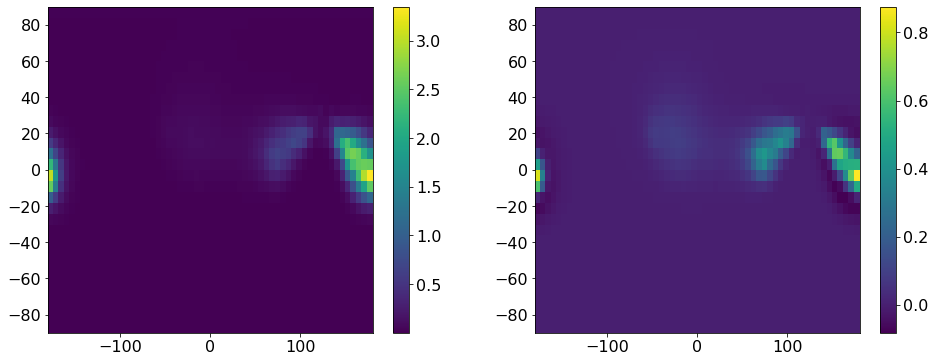

Convolving Delta image, iteration 12



Finding maximum acceleration parameter, iteration 12
Maximum acceleration parameter found:  0.552
Fitting delta-map in addition to old map, iteration 12
Saving new map, and fitted parameters, iteration 12
Calculating Delta image, iteration 13, numerator


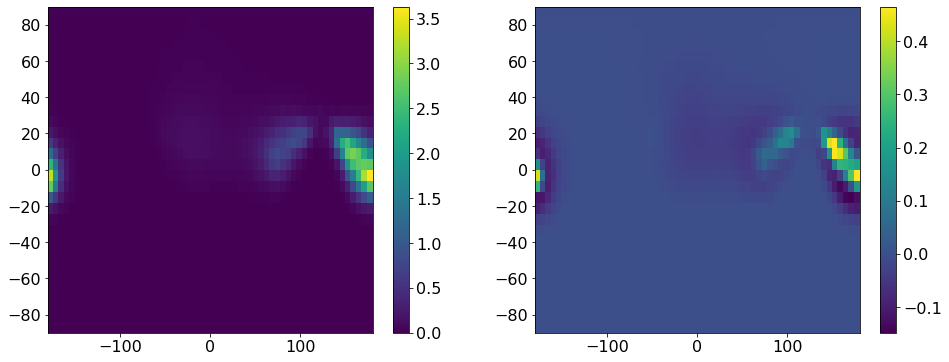

Convolving Delta image, iteration 13



Finding maximum acceleration parameter, iteration 13
Maximum acceleration parameter found:  0.502
Fitting delta-map in addition to old map, iteration 13
Saving new map, and fitted parameters, iteration 13
Calculating Delta image, iteration 14, numerator


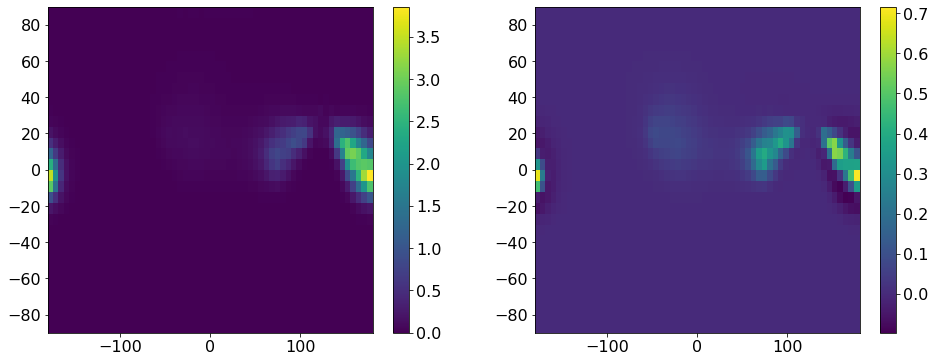

Convolving Delta image, iteration 14



Finding maximum acceleration parameter, iteration 14
Maximum acceleration parameter found:  0.541
Fitting delta-map in addition to old map, iteration 14
Saving new map, and fitted parameters, iteration 14
Calculating Delta image, iteration 15, numerator


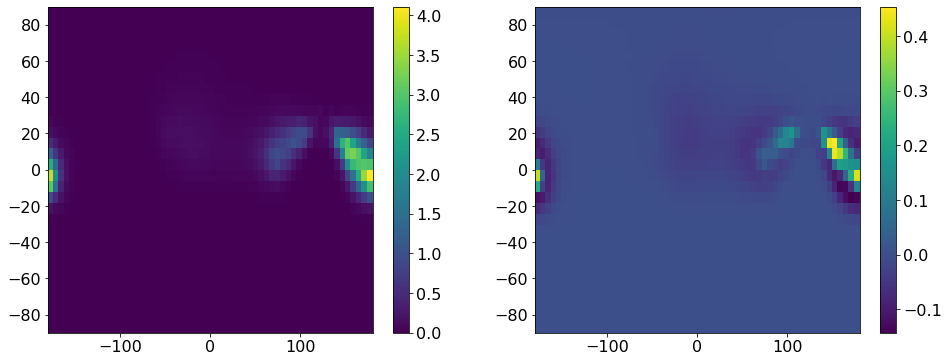

Convolving Delta image, iteration 15



Finding maximum acceleration parameter, iteration 15
Maximum acceleration parameter found:  0.505
Fitting delta-map in addition to old map, iteration 15
Saving new map, and fitted parameters, iteration 15
Calculating Delta image, iteration 16, numerator


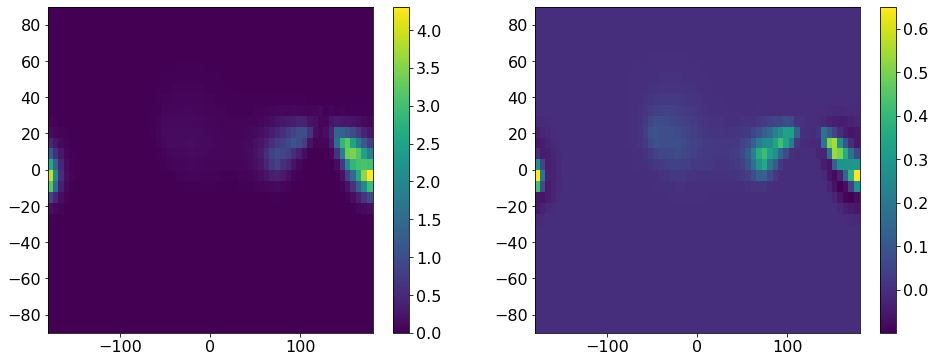

Convolving Delta image, iteration 16



Finding maximum acceleration parameter, iteration 16
Maximum acceleration parameter found:  0.541
Fitting delta-map in addition to old map, iteration 16
Saving new map, and fitted parameters, iteration 16
Calculating Delta image, iteration 17, numerator


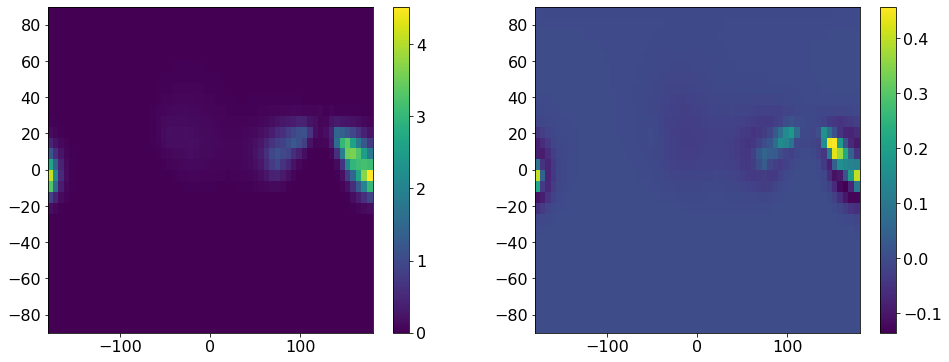

Convolving Delta image, iteration 17



Finding maximum acceleration parameter, iteration 17
Maximum acceleration parameter found:  0.511
Fitting delta-map in addition to old map, iteration 17
Saving new map, and fitted parameters, iteration 17
Calculating Delta image, iteration 18, numerator


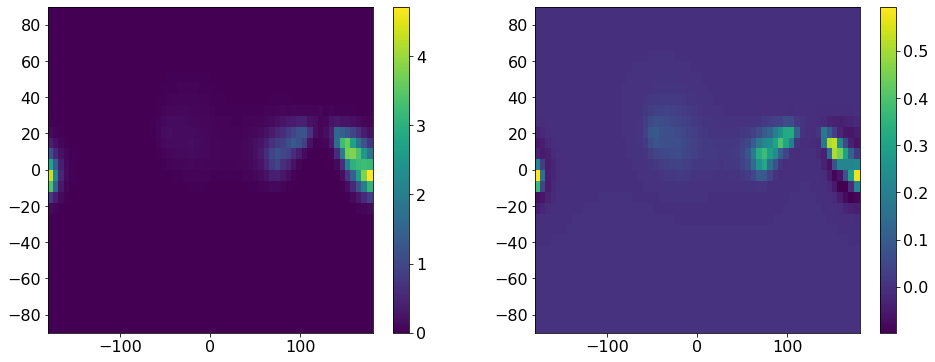

Convolving Delta image, iteration 18



Finding maximum acceleration parameter, iteration 18
Maximum acceleration parameter found:  0.538
Fitting delta-map in addition to old map, iteration 18
Saving new map, and fitted parameters, iteration 18
Calculating Delta image, iteration 19, numerator


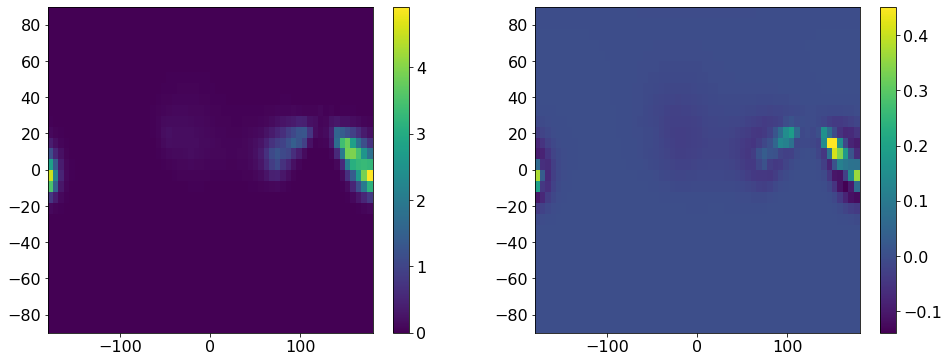

Convolving Delta image, iteration 19



Finding maximum acceleration parameter, iteration 19
Maximum acceleration parameter found:  0.513
Fitting delta-map in addition to old map, iteration 19
Saving new map, and fitted parameters, iteration 19
Calculating Delta image, iteration 20, numerator


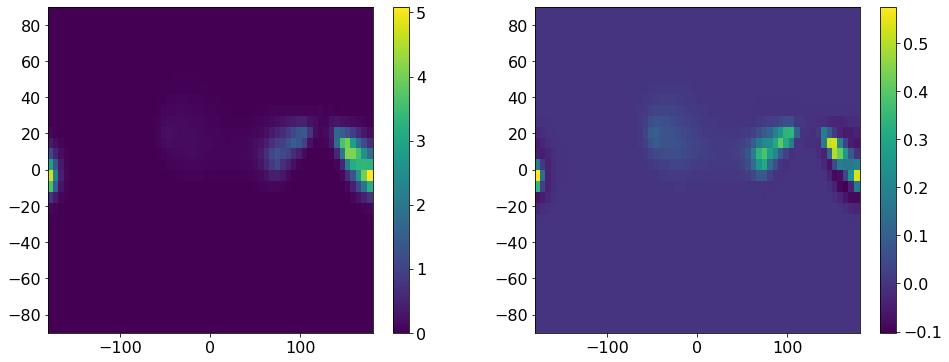

Convolving Delta image, iteration 20



Finding maximum acceleration parameter, iteration 20
Maximum acceleration parameter found:  0.539
Fitting delta-map in addition to old map, iteration 20
Saving new map, and fitted parameters, iteration 20
Calculating Delta image, iteration 21, numerator


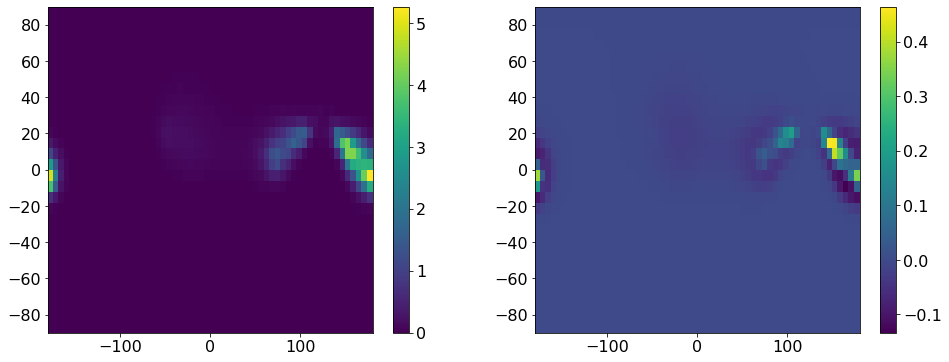

Convolving Delta image, iteration 21



Finding maximum acceleration parameter, iteration 21
Maximum acceleration parameter found:  0.517
Fitting delta-map in addition to old map, iteration 21
Saving new map, and fitted parameters, iteration 21
Calculating Delta image, iteration 22, numerator


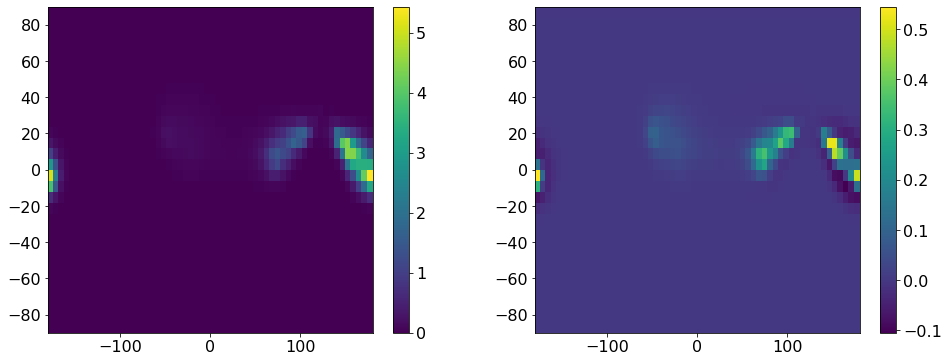

Convolving Delta image, iteration 22



Finding maximum acceleration parameter, iteration 22
Maximum acceleration parameter found:  0.539
Fitting delta-map in addition to old map, iteration 22
Saving new map, and fitted parameters, iteration 22
Calculating Delta image, iteration 23, numerator


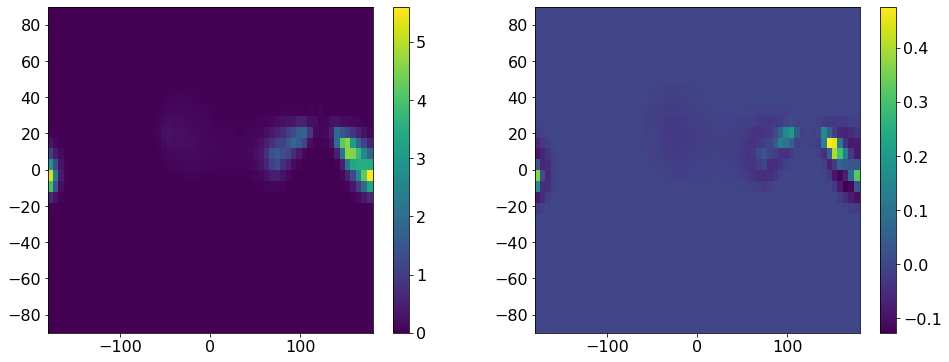

Convolving Delta image, iteration 23



Finding maximum acceleration parameter, iteration 23
Maximum acceleration parameter found:  0.52
Fitting delta-map in addition to old map, iteration 23
Saving new map, and fitted parameters, iteration 23
Calculating Delta image, iteration 24, numerator


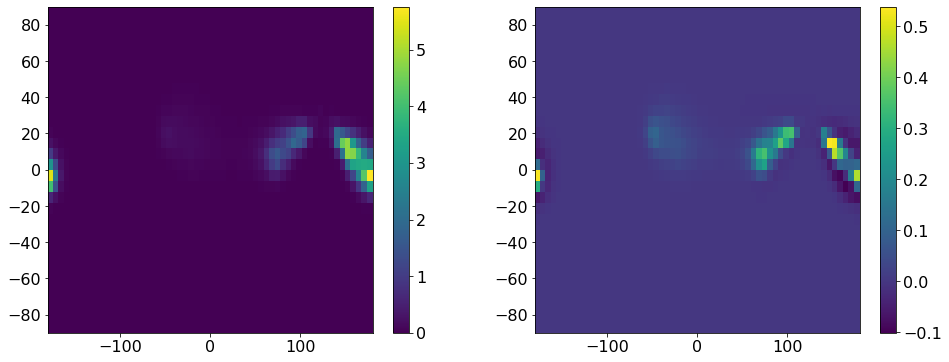

Convolving Delta image, iteration 24



Finding maximum acceleration parameter, iteration 24
Maximum acceleration parameter found:  0.541
Fitting delta-map in addition to old map, iteration 24
Saving new map, and fitted parameters, iteration 24
Calculating Delta image, iteration 25, numerator


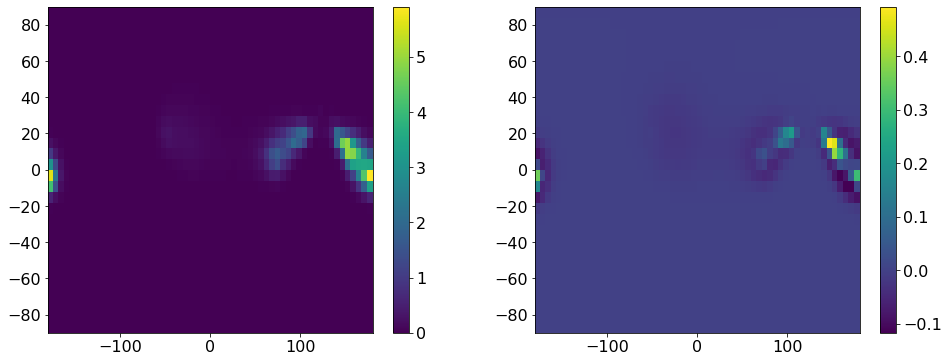

Convolving Delta image, iteration 25



Finding maximum acceleration parameter, iteration 25
Maximum acceleration parameter found:  0.524
Fitting delta-map in addition to old map, iteration 25
Saving new map, and fitted parameters, iteration 25
Calculating Delta image, iteration 26, numerator


Convolving Delta image, iteration 26



Finding maximum acceleration parameter, iteration 26
Maximum acceleration parameter found:  0.541
Fitting delta-map in addition to old map, iteration 26
Saving new map, and fitted parameters, iteration 26
Calculating Delta image, iteration 27, numerator


Convolving Delta image, iteration 27



Finding maximum acceleration parameter, iteration 27
Maximum acceleration parameter found:  0.527
Fitting delta-map in addition to old map, iteration 27
Saving new map, and fitted parameters, iteration 27
Calculating Delta image, iteration 28, numerator


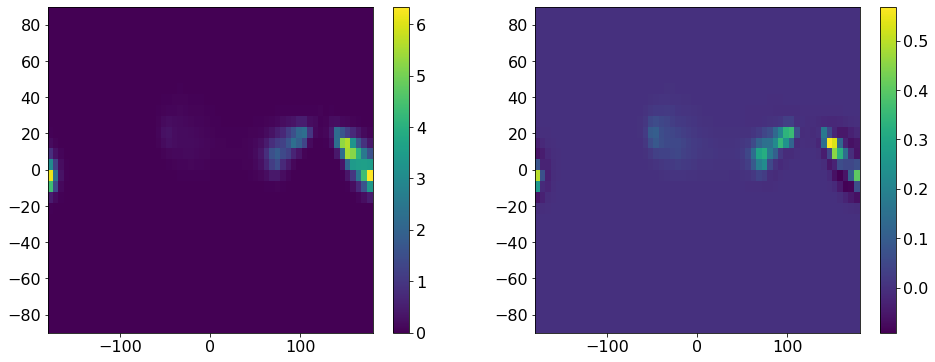

Convolving Delta image, iteration 28



Finding maximum acceleration parameter, iteration 28
Maximum acceleration parameter found:  0.544
Fitting delta-map in addition to old map, iteration 28
Saving new map, and fitted parameters, iteration 28
Calculating Delta image, iteration 29, numerator


Convolving Delta image, iteration 29



Finding maximum acceleration parameter, iteration 29
Maximum acceleration parameter found:  0.53
Fitting delta-map in addition to old map, iteration 29
Saving new map, and fitted parameters, iteration 29
Calculating Delta image, iteration 30, numerator


Convolving Delta image, iteration 30



Finding maximum acceleration parameter, iteration 30
Maximum acceleration parameter found:  0.545
Fitting delta-map in addition to old map, iteration 30
Saving new map, and fitted parameters, iteration 30
Calculating Delta image, iteration 31, numerator


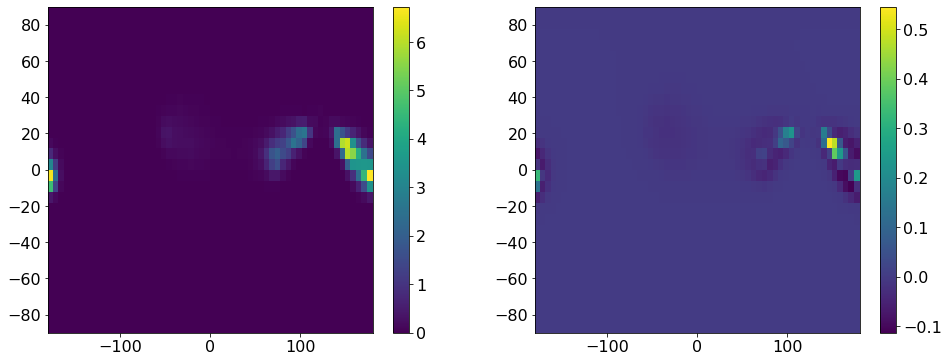

Convolving Delta image, iteration 31



Finding maximum acceleration parameter, iteration 31
Maximum acceleration parameter found:  0.532
Fitting delta-map in addition to old map, iteration 31
Saving new map, and fitted parameters, iteration 31
Calculating Delta image, iteration 32, numerator


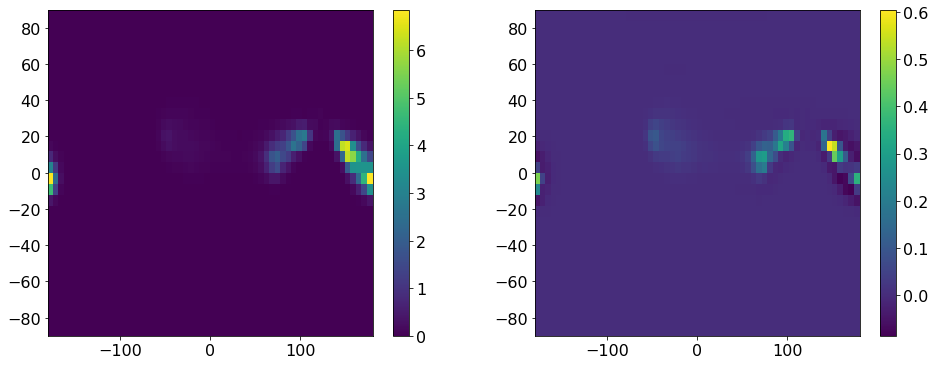

Convolving Delta image, iteration 32



Finding maximum acceleration parameter, iteration 32
Maximum acceleration parameter found:  0.547
Fitting delta-map in addition to old map, iteration 32
Saving new map, and fitted parameters, iteration 32
Calculating Delta image, iteration 33, numerator


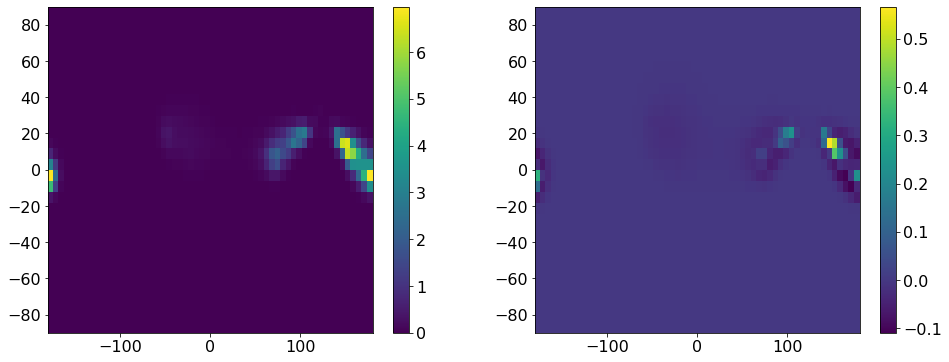

Convolving Delta image, iteration 33



Finding maximum acceleration parameter, iteration 33
Maximum acceleration parameter found:  0.535
Fitting delta-map in addition to old map, iteration 33
Saving new map, and fitted parameters, iteration 33
Calculating Delta image, iteration 34, numerator


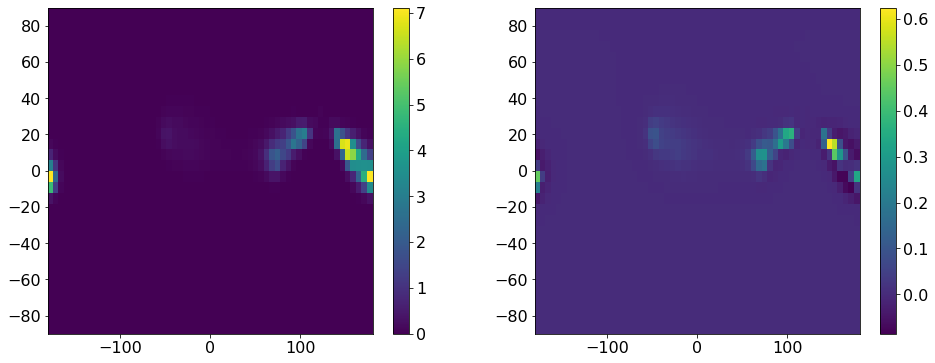

Convolving Delta image, iteration 34



Finding maximum acceleration parameter, iteration 34
Maximum acceleration parameter found:  0.548
Fitting delta-map in addition to old map, iteration 34
Saving new map, and fitted parameters, iteration 34
Calculating Delta image, iteration 35, numerator


Convolving Delta image, iteration 35



Finding maximum acceleration parameter, iteration 35
Maximum acceleration parameter found:  0.537
Fitting delta-map in addition to old map, iteration 35
Saving new map, and fitted parameters, iteration 35
Calculating Delta image, iteration 36, numerator


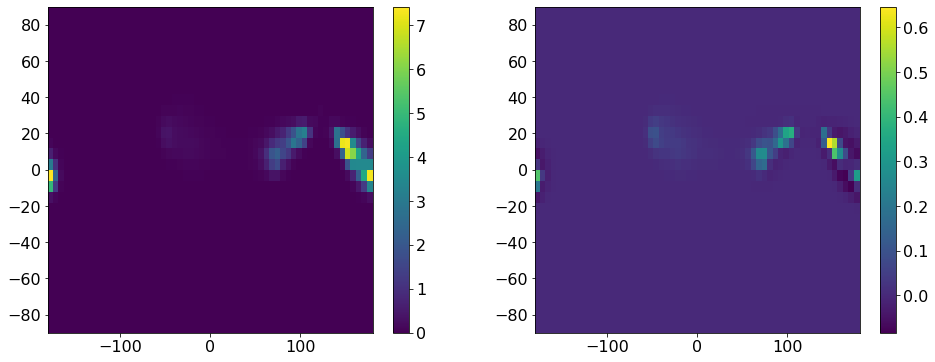

Convolving Delta image, iteration 36



Finding maximum acceleration parameter, iteration 36
Maximum acceleration parameter found:  0.55
Fitting delta-map in addition to old map, iteration 36
Saving new map, and fitted parameters, iteration 36
Calculating Delta image, iteration 37, numerator


Convolving Delta image, iteration 37



Finding maximum acceleration parameter, iteration 37
Maximum acceleration parameter found:  0.54
Fitting delta-map in addition to old map, iteration 37
Saving new map, and fitted parameters, iteration 37
Calculating Delta image, iteration 38, numerator


Convolving Delta image, iteration 38



Finding maximum acceleration parameter, iteration 38
Maximum acceleration parameter found:  0.552
Fitting delta-map in addition to old map, iteration 38
Saving new map, and fitted parameters, iteration 38
Calculating Delta image, iteration 39, numerator


Convolving Delta image, iteration 39



Finding maximum acceleration parameter, iteration 39
Maximum acceleration parameter found:  0.542
Fitting delta-map in addition to old map, iteration 39
Saving new map, and fitted parameters, iteration 39
Calculating Delta image, iteration 40, numerator


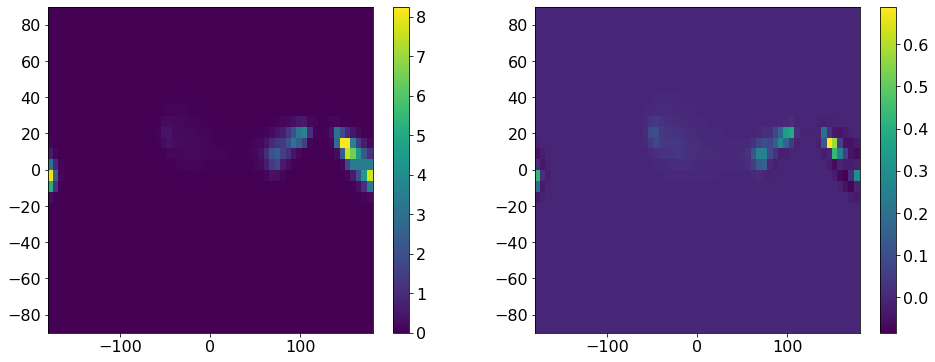

Convolving Delta image, iteration 40



Finding maximum acceleration parameter, iteration 40
Maximum acceleration parameter found:  0.553
Fitting delta-map in addition to old map, iteration 40
Saving new map, and fitted parameters, iteration 40
Calculating Delta image, iteration 41, numerator


Convolving Delta image, iteration 41



Finding maximum acceleration parameter, iteration 41
Maximum acceleration parameter found:  0.544
Fitting delta-map in addition to old map, iteration 41
Saving new map, and fitted parameters, iteration 41
Calculating Delta image, iteration 42, numerator


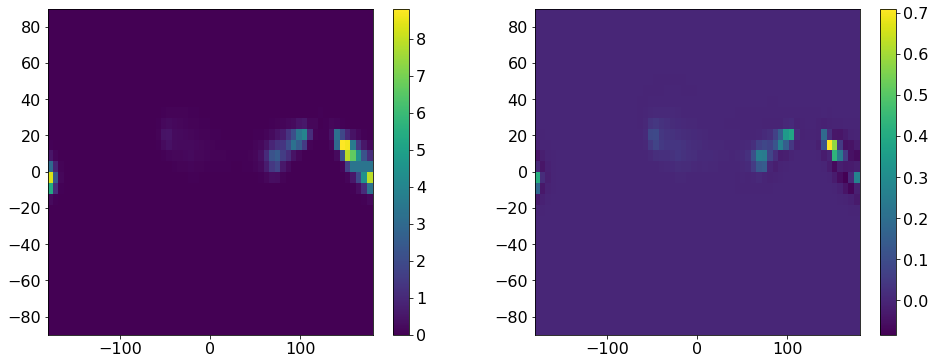

Convolving Delta image, iteration 42



Finding maximum acceleration parameter, iteration 42
Maximum acceleration parameter found:  0.555
Fitting delta-map in addition to old map, iteration 42
Saving new map, and fitted parameters, iteration 42
Calculating Delta image, iteration 43, numerator


Convolving Delta image, iteration 43



Finding maximum acceleration parameter, iteration 43
Maximum acceleration parameter found:  0.546
Fitting delta-map in addition to old map, iteration 43
Saving new map, and fitted parameters, iteration 43
Calculating Delta image, iteration 44, numerator


Convolving Delta image, iteration 44



Finding maximum acceleration parameter, iteration 44
Maximum acceleration parameter found:  0.556
Fitting delta-map in addition to old map, iteration 44
Saving new map, and fitted parameters, iteration 44
Calculating Delta image, iteration 45, numerator


Convolving Delta image, iteration 45



Finding maximum acceleration parameter, iteration 45
Maximum acceleration parameter found:  0.548
Fitting delta-map in addition to old map, iteration 45
Saving new map, and fitted parameters, iteration 45
Calculating Delta image, iteration 46, numerator


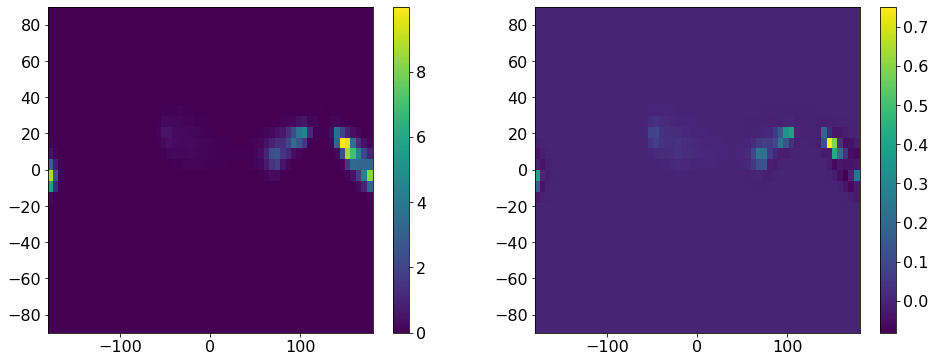

Convolving Delta image, iteration 46



Finding maximum acceleration parameter, iteration 46
Maximum acceleration parameter found:  0.558
Fitting delta-map in addition to old map, iteration 46
Saving new map, and fitted parameters, iteration 46
Calculating Delta image, iteration 47, numerator


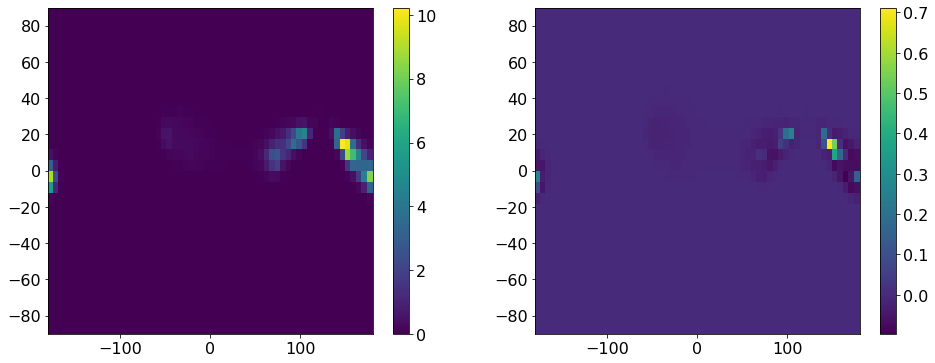

Convolving Delta image, iteration 47



Finding maximum acceleration parameter, iteration 47
Maximum acceleration parameter found:  0.55
Fitting delta-map in addition to old map, iteration 47
Saving new map, and fitted parameters, iteration 47
Calculating Delta image, iteration 48, numerator


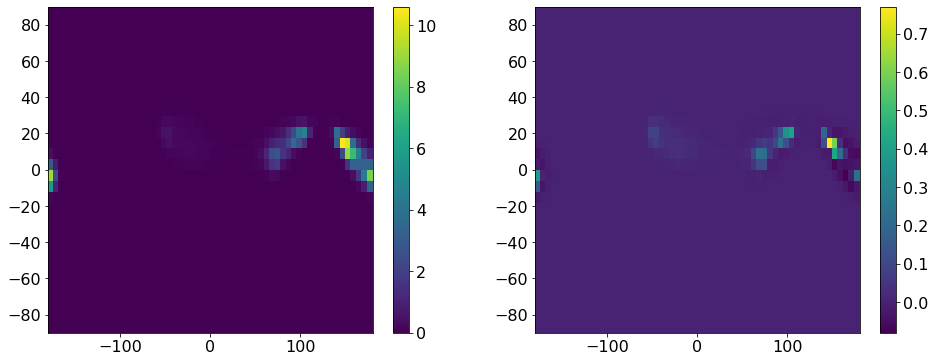

Convolving Delta image, iteration 48



Finding maximum acceleration parameter, iteration 48
Maximum acceleration parameter found:  0.559
Fitting delta-map in addition to old map, iteration 48
Saving new map, and fitted parameters, iteration 48
Calculating Delta image, iteration 49, numerator


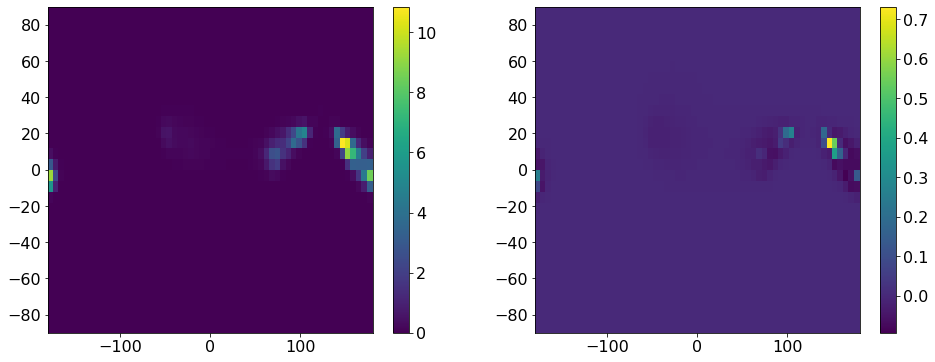

Convolving Delta image, iteration 49



Finding maximum acceleration parameter, iteration 49
Maximum acceleration parameter found:  0.551
Fitting delta-map in addition to old map, iteration 49
Saving new map, and fitted parameters, iteration 49
Calculating Delta image, iteration 50, numerator


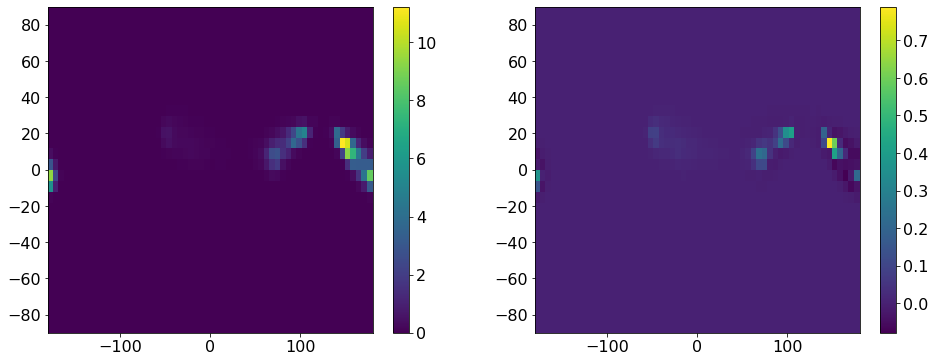

Convolving Delta image, iteration 50



Finding maximum acceleration parameter, iteration 50
Maximum acceleration parameter found:  0.56
Fitting delta-map in addition to old map, iteration 50
Saving new map, and fitted parameters, iteration 50
Calculating Delta image, iteration 51, numerator


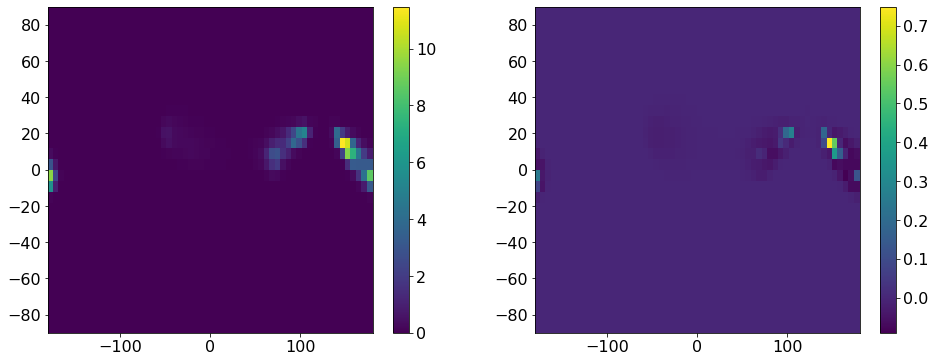

Convolving Delta image, iteration 51



Finding maximum acceleration parameter, iteration 51
Maximum acceleration parameter found:  0.553
Fitting delta-map in addition to old map, iteration 51
Saving new map, and fitted parameters, iteration 51
Calculating Delta image, iteration 52, numerator


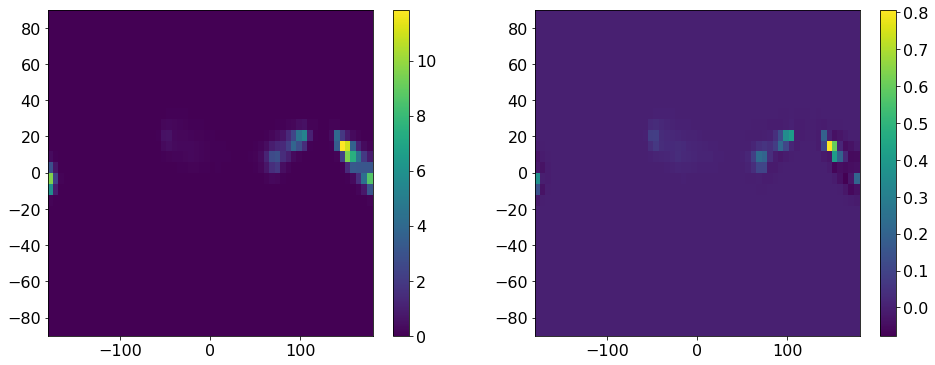

Convolving Delta image, iteration 52



Finding maximum acceleration parameter, iteration 52
Maximum acceleration parameter found:  0.562
Fitting delta-map in addition to old map, iteration 52
Saving new map, and fitted parameters, iteration 52
Calculating Delta image, iteration 53, numerator


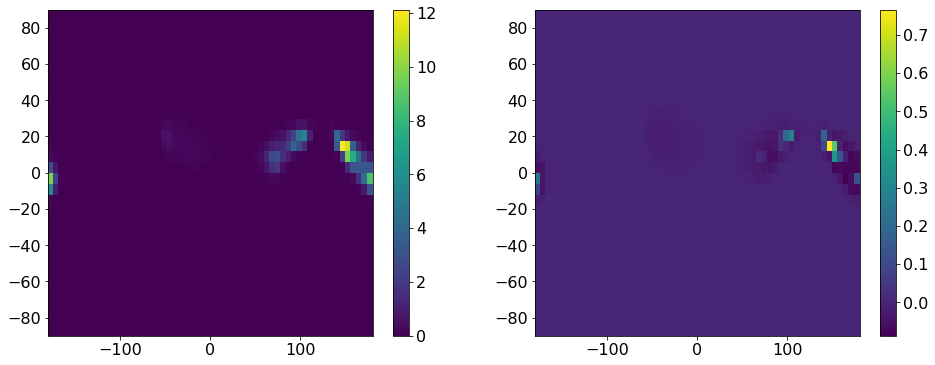

Convolving Delta image, iteration 53



Finding maximum acceleration parameter, iteration 53
Maximum acceleration parameter found:  0.555
Fitting delta-map in addition to old map, iteration 53
Saving new map, and fitted parameters, iteration 53
Calculating Delta image, iteration 54, numerator


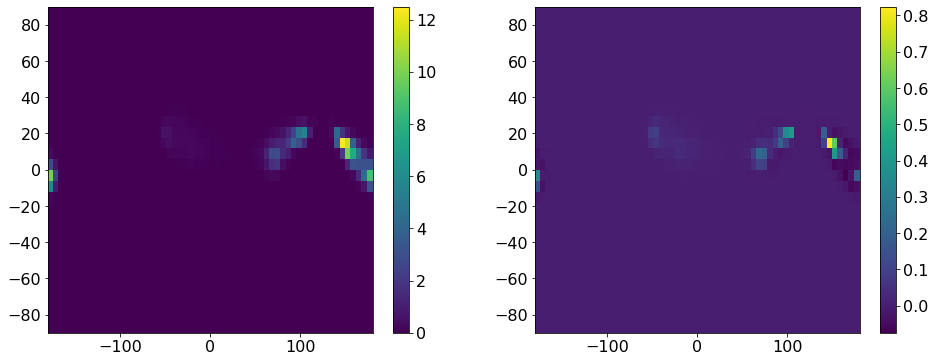

Convolving Delta image, iteration 54



Finding maximum acceleration parameter, iteration 54
Maximum acceleration parameter found:  0.563
Fitting delta-map in addition to old map, iteration 54
Saving new map, and fitted parameters, iteration 54
Calculating Delta image, iteration 55, numerator


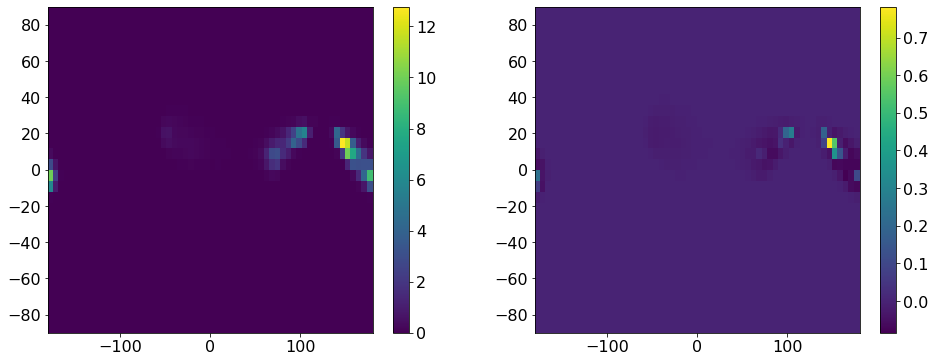

Convolving Delta image, iteration 55



Finding maximum acceleration parameter, iteration 55
Maximum acceleration parameter found:  0.556
Fitting delta-map in addition to old map, iteration 55
Saving new map, and fitted parameters, iteration 55
Calculating Delta image, iteration 56, numerator


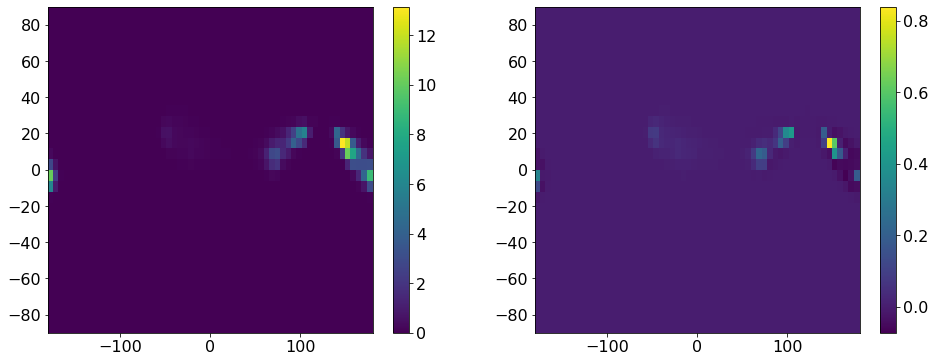

Convolving Delta image, iteration 56



Finding maximum acceleration parameter, iteration 56
Maximum acceleration parameter found:  0.564
Fitting delta-map in addition to old map, iteration 56
Saving new map, and fitted parameters, iteration 56
Calculating Delta image, iteration 57, numerator


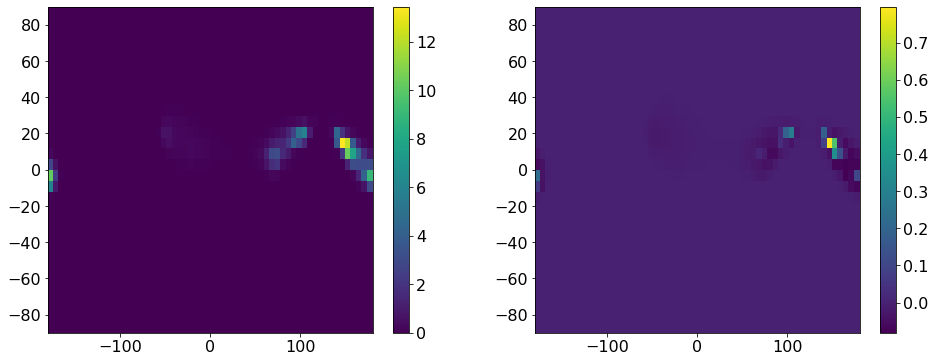

Convolving Delta image, iteration 57



Finding maximum acceleration parameter, iteration 57
Maximum acceleration parameter found:  0.558
Fitting delta-map in addition to old map, iteration 57
Saving new map, and fitted parameters, iteration 57
Calculating Delta image, iteration 58, numerator


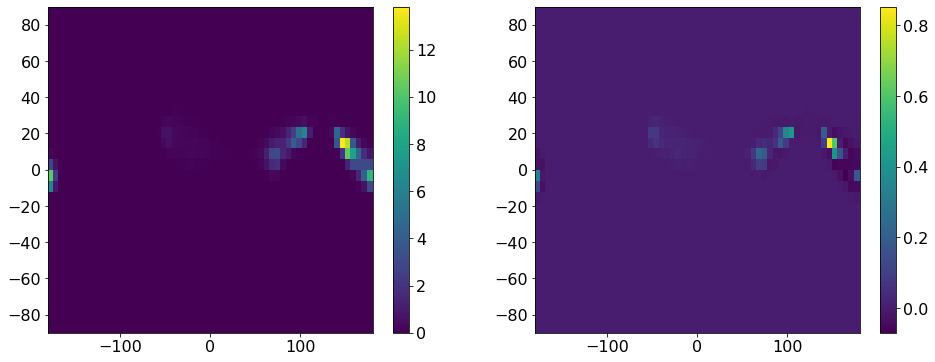

Convolving Delta image, iteration 58



Finding maximum acceleration parameter, iteration 58
Maximum acceleration parameter found:  0.566
Fitting delta-map in addition to old map, iteration 58
Saving new map, and fitted parameters, iteration 58
Calculating Delta image, iteration 59, numerator


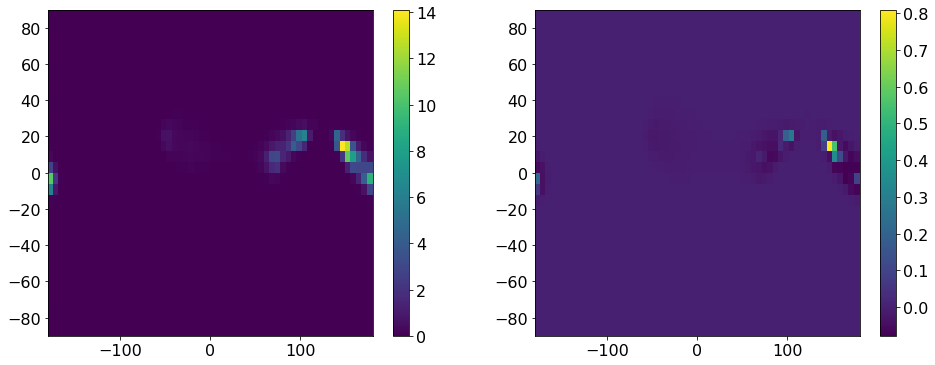

Convolving Delta image, iteration 59



Finding maximum acceleration parameter, iteration 59
Maximum acceleration parameter found:  0.559
Fitting delta-map in addition to old map, iteration 59
Saving new map, and fitted parameters, iteration 59
Calculating Delta image, iteration 60, numerator


Convolving Delta image, iteration 60



Finding maximum acceleration parameter, iteration 60
Maximum acceleration parameter found:  0.567
Fitting delta-map in addition to old map, iteration 60
Saving new map, and fitted parameters, iteration 60
Calculating Delta image, iteration 61, numerator


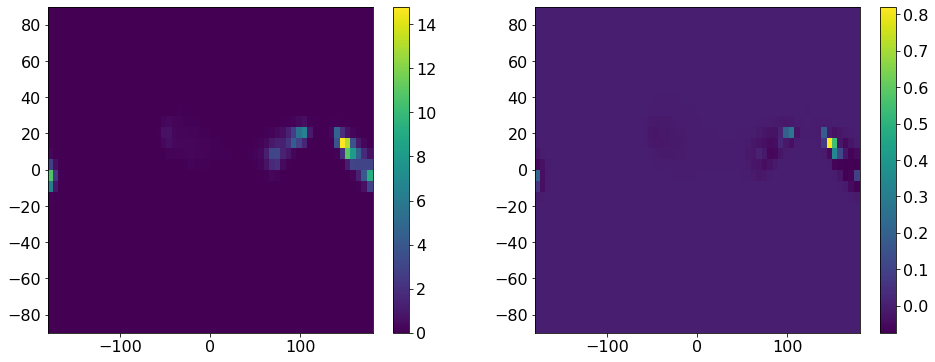

Convolving Delta image, iteration 61



Finding maximum acceleration parameter, iteration 61
Maximum acceleration parameter found:  0.561
Fitting delta-map in addition to old map, iteration 61
Saving new map, and fitted parameters, iteration 61
Calculating Delta image, iteration 62, numerator


Convolving Delta image, iteration 62



Finding maximum acceleration parameter, iteration 62
Maximum acceleration parameter found:  0.568
Fitting delta-map in addition to old map, iteration 62
Saving new map, and fitted parameters, iteration 62
Calculating Delta image, iteration 63, numerator


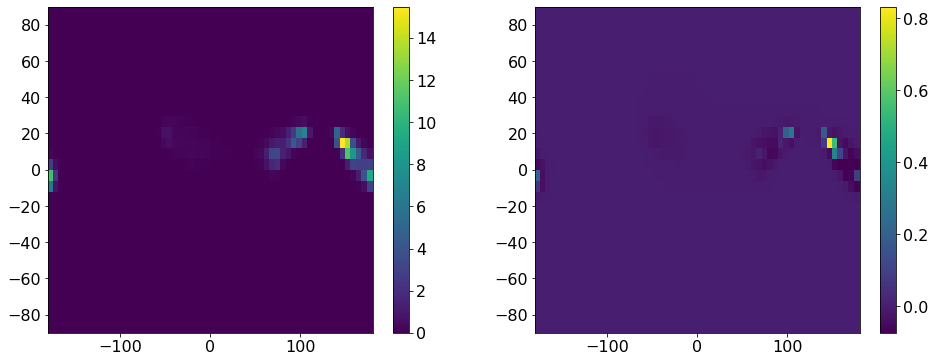

Convolving Delta image, iteration 63



Finding maximum acceleration parameter, iteration 63
Maximum acceleration parameter found:  0.562
Fitting delta-map in addition to old map, iteration 63
Saving new map, and fitted parameters, iteration 63
Calculating Delta image, iteration 64, numerator


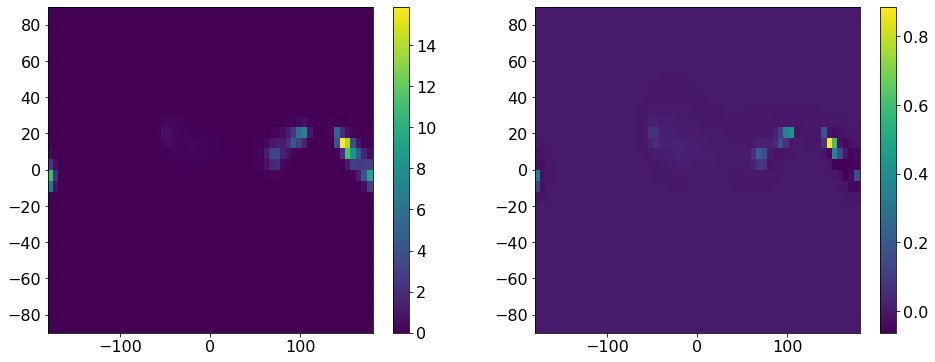

Convolving Delta image, iteration 64



Finding maximum acceleration parameter, iteration 64
Maximum acceleration parameter found:  0.569
Fitting delta-map in addition to old map, iteration 64
Saving new map, and fitted parameters, iteration 64
Calculating Delta image, iteration 65, numerator


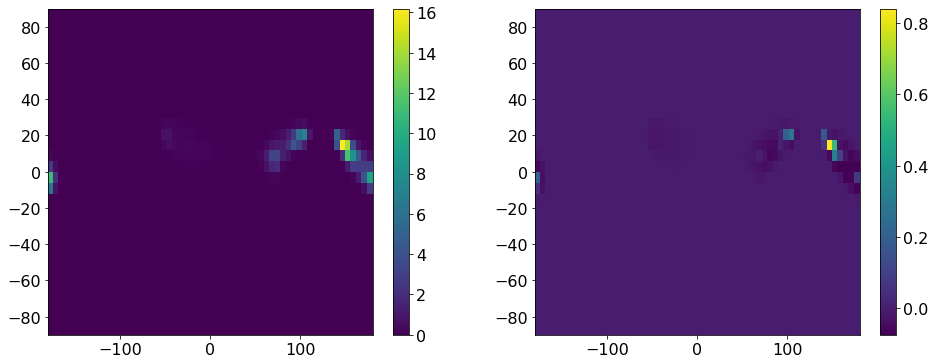

Convolving Delta image, iteration 65



Finding maximum acceleration parameter, iteration 65
Maximum acceleration parameter found:  0.563
Fitting delta-map in addition to old map, iteration 65
Saving new map, and fitted parameters, iteration 65
Calculating Delta image, iteration 66, numerator


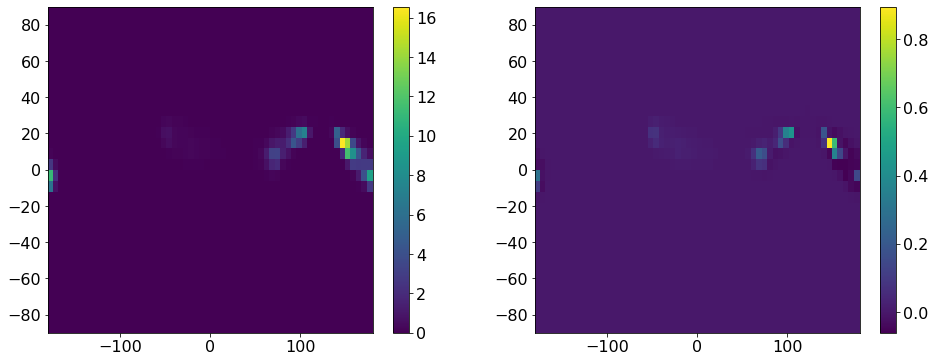

Convolving Delta image, iteration 66



Finding maximum acceleration parameter, iteration 66
Maximum acceleration parameter found:  0.571
Fitting delta-map in addition to old map, iteration 66
Saving new map, and fitted parameters, iteration 66
Calculating Delta image, iteration 67, numerator


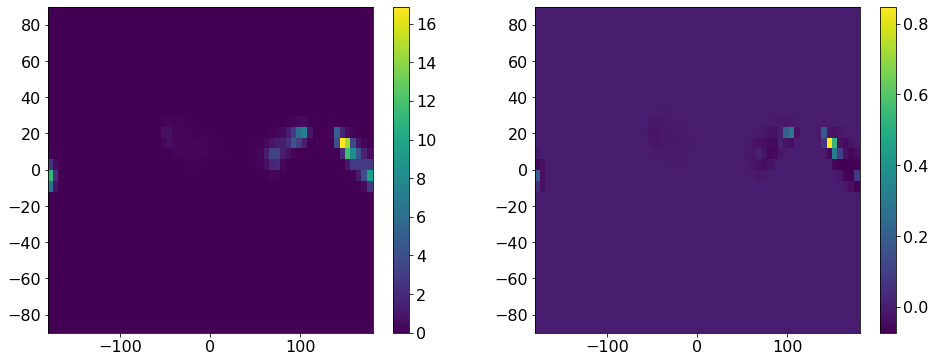

Convolving Delta image, iteration 67



Finding maximum acceleration parameter, iteration 67
Maximum acceleration parameter found:  0.565
Fitting delta-map in addition to old map, iteration 67
Saving new map, and fitted parameters, iteration 67
Calculating Delta image, iteration 68, numerator


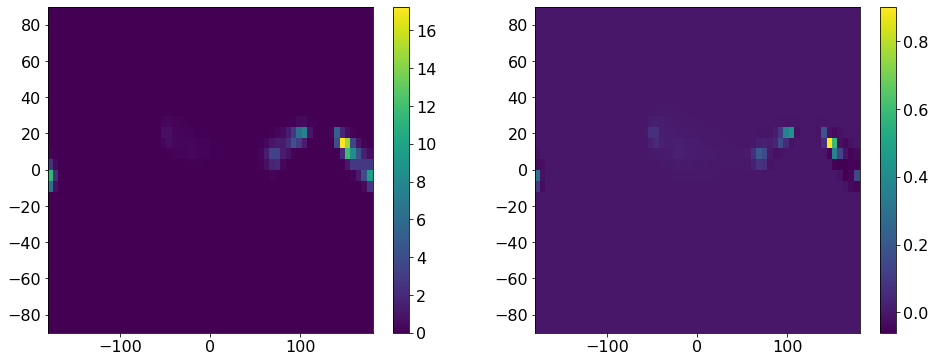

Convolving Delta image, iteration 68



Finding maximum acceleration parameter, iteration 68
Maximum acceleration parameter found:  0.572
Fitting delta-map in addition to old map, iteration 68
Saving new map, and fitted parameters, iteration 68
Calculating Delta image, iteration 69, numerator


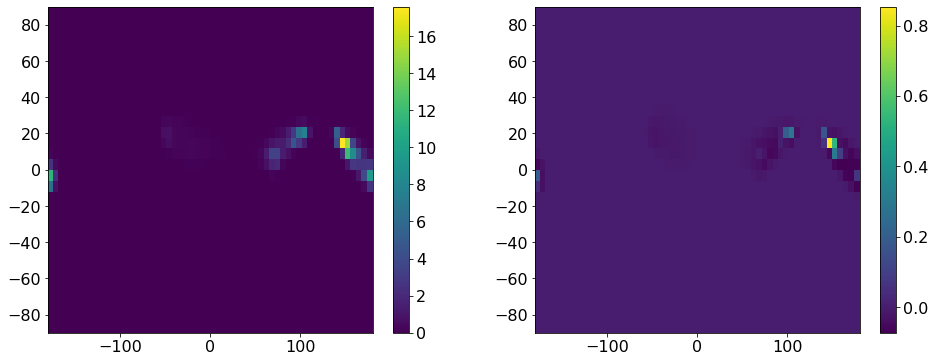

Convolving Delta image, iteration 69



Finding maximum acceleration parameter, iteration 69
Maximum acceleration parameter found:  0.566
Fitting delta-map in addition to old map, iteration 69
Saving new map, and fitted parameters, iteration 69
Calculating Delta image, iteration 70, numerator


Convolving Delta image, iteration 70



Finding maximum acceleration parameter, iteration 70
Maximum acceleration parameter found:  0.573
Fitting delta-map in addition to old map, iteration 70
Saving new map, and fitted parameters, iteration 70
Calculating Delta image, iteration 71, numerator


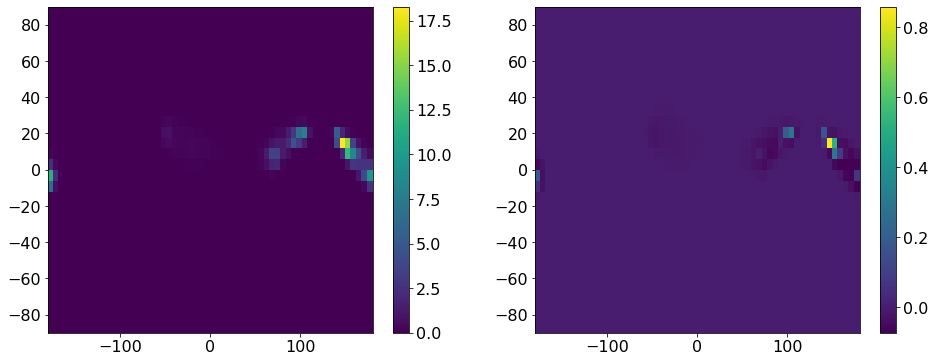

Convolving Delta image, iteration 71



Finding maximum acceleration parameter, iteration 71
Maximum acceleration parameter found:  0.568
Fitting delta-map in addition to old map, iteration 71
Saving new map, and fitted parameters, iteration 71
Calculating Delta image, iteration 72, numerator


Convolving Delta image, iteration 72



Finding maximum acceleration parameter, iteration 72
Maximum acceleration parameter found:  0.574
Fitting delta-map in addition to old map, iteration 72
Saving new map, and fitted parameters, iteration 72
Calculating Delta image, iteration 73, numerator


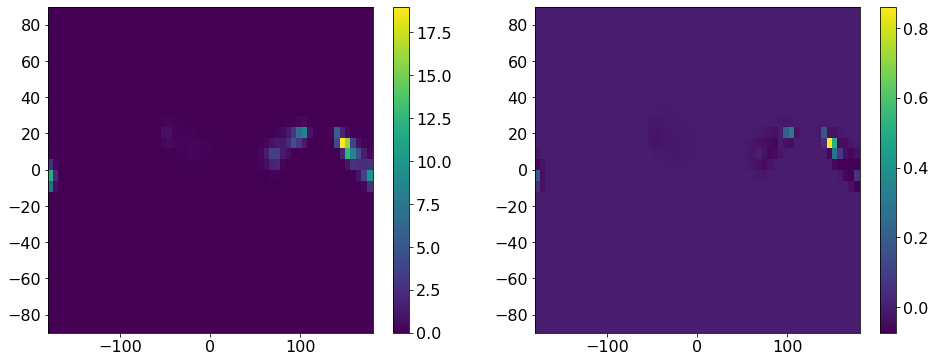

Convolving Delta image, iteration 73



Finding maximum acceleration parameter, iteration 73
Maximum acceleration parameter found:  0.569
Fitting delta-map in addition to old map, iteration 73
Saving new map, and fitted parameters, iteration 73
Calculating Delta image, iteration 74, numerator


Convolving Delta image, iteration 74



Finding maximum acceleration parameter, iteration 74
Maximum acceleration parameter found:  0.576
Fitting delta-map in addition to old map, iteration 74
Saving new map, and fitted parameters, iteration 74
Calculating Delta image, iteration 75, numerator


Convolving Delta image, iteration 75



Finding maximum acceleration parameter, iteration 75
Maximum acceleration parameter found:  0.57
Fitting delta-map in addition to old map, iteration 75
Saving new map, and fitted parameters, iteration 75
Calculating Delta image, iteration 76, numerator


Convolving Delta image, iteration 76



Finding maximum acceleration parameter, iteration 76
Maximum acceleration parameter found:  0.577
Fitting delta-map in addition to old map, iteration 76
Saving new map, and fitted parameters, iteration 76
Calculating Delta image, iteration 77, numerator


Convolving Delta image, iteration 77



Finding maximum acceleration parameter, iteration 77
Maximum acceleration parameter found:  0.572
Fitting delta-map in addition to old map, iteration 77
Saving new map, and fitted parameters, iteration 77
Calculating Delta image, iteration 78, numerator


Convolving Delta image, iteration 78



Finding maximum acceleration parameter, iteration 78
Maximum acceleration parameter found:  0.578
Fitting delta-map in addition to old map, iteration 78
Saving new map, and fitted parameters, iteration 78
Calculating Delta image, iteration 79, numerator


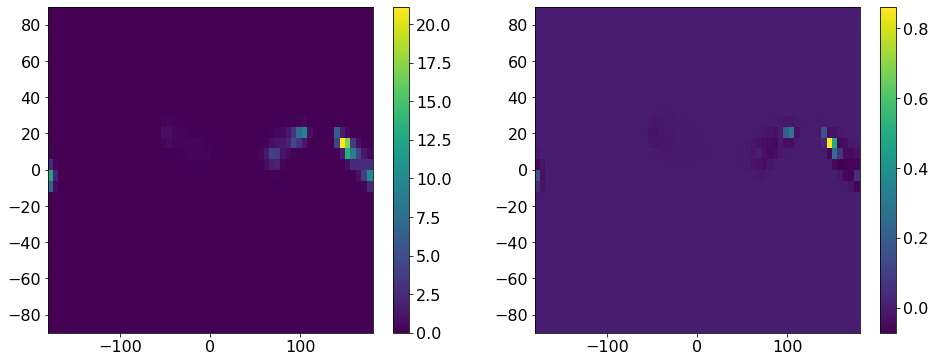

Convolving Delta image, iteration 79



Finding maximum acceleration parameter, iteration 79
Maximum acceleration parameter found:  0.573
Fitting delta-map in addition to old map, iteration 79
Saving new map, and fitted parameters, iteration 79
Calculating Delta image, iteration 80, numerator


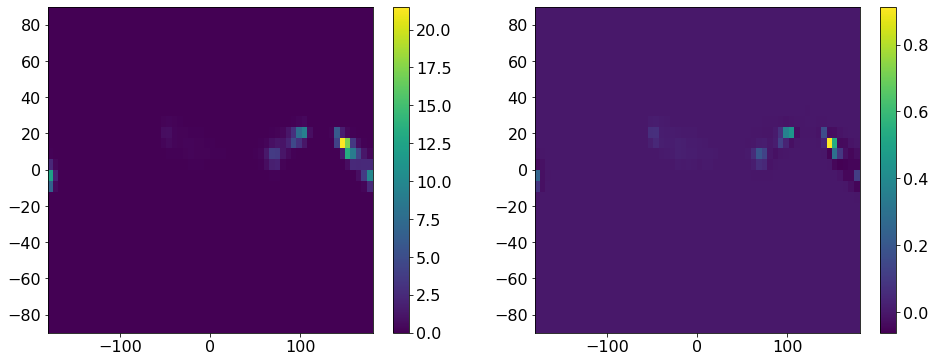

Convolving Delta image, iteration 80



Finding maximum acceleration parameter, iteration 80
Maximum acceleration parameter found:  0.579
Fitting delta-map in addition to old map, iteration 80
Saving new map, and fitted parameters, iteration 80
Calculating Delta image, iteration 81, numerator


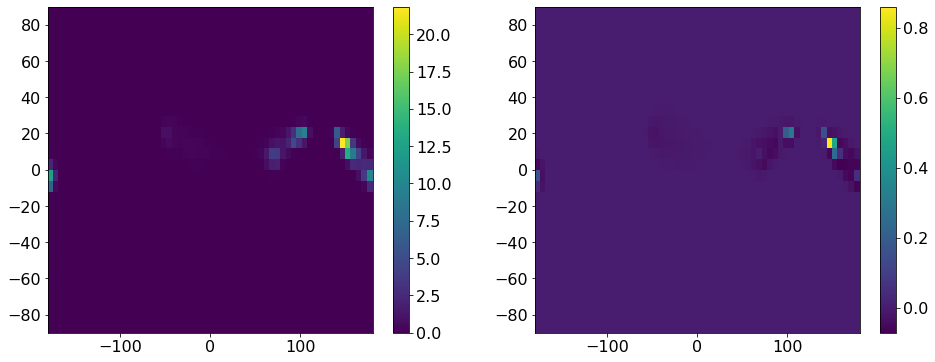

Convolving Delta image, iteration 81



Finding maximum acceleration parameter, iteration 81
Maximum acceleration parameter found:  0.574
Fitting delta-map in addition to old map, iteration 81
Saving new map, and fitted parameters, iteration 81
Calculating Delta image, iteration 82, numerator


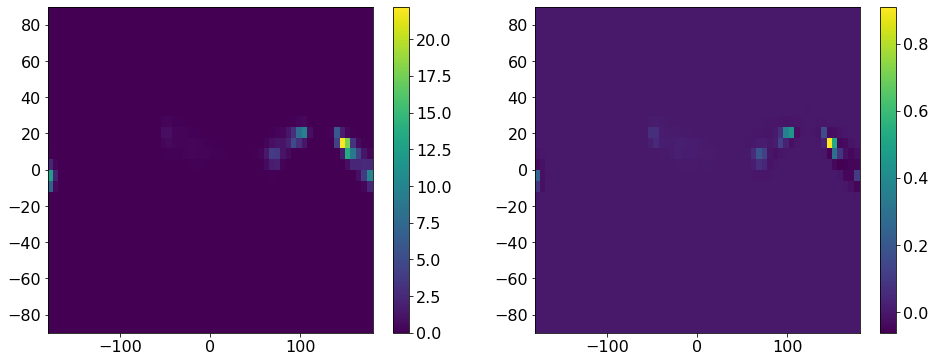

Convolving Delta image, iteration 82



Finding maximum acceleration parameter, iteration 82
Maximum acceleration parameter found:  0.58
Fitting delta-map in addition to old map, iteration 82
Saving new map, and fitted parameters, iteration 82
Calculating Delta image, iteration 83, numerator


Convolving Delta image, iteration 83



Finding maximum acceleration parameter, iteration 83
Maximum acceleration parameter found:  0.576
Fitting delta-map in addition to old map, iteration 83
Saving new map, and fitted parameters, iteration 83
Calculating Delta image, iteration 84, numerator


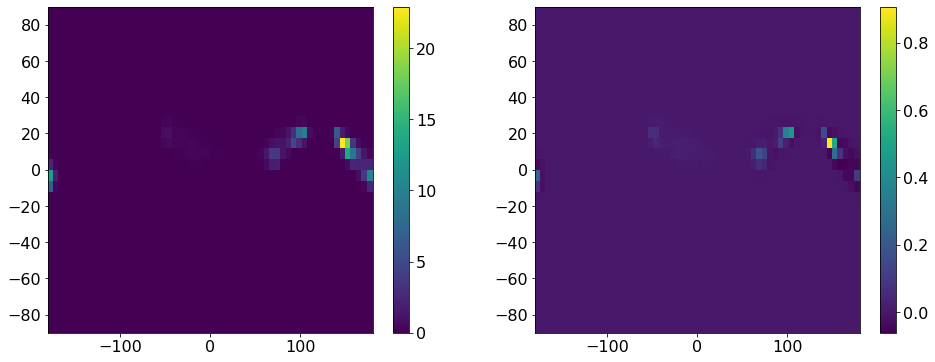

Convolving Delta image, iteration 84



Finding maximum acceleration parameter, iteration 84
Maximum acceleration parameter found:  0.582
Fitting delta-map in addition to old map, iteration 84
Saving new map, and fitted parameters, iteration 84
Calculating Delta image, iteration 85, numerator


Convolving Delta image, iteration 85



Finding maximum acceleration parameter, iteration 85
Maximum acceleration parameter found:  0.577
Fitting delta-map in addition to old map, iteration 85
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 86, numerator


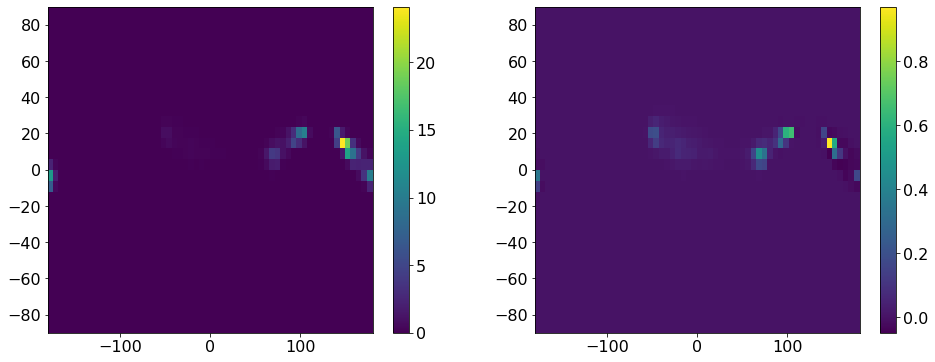

Convolving Delta image, iteration 86



Finding maximum acceleration parameter, iteration 86
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 87, numerator


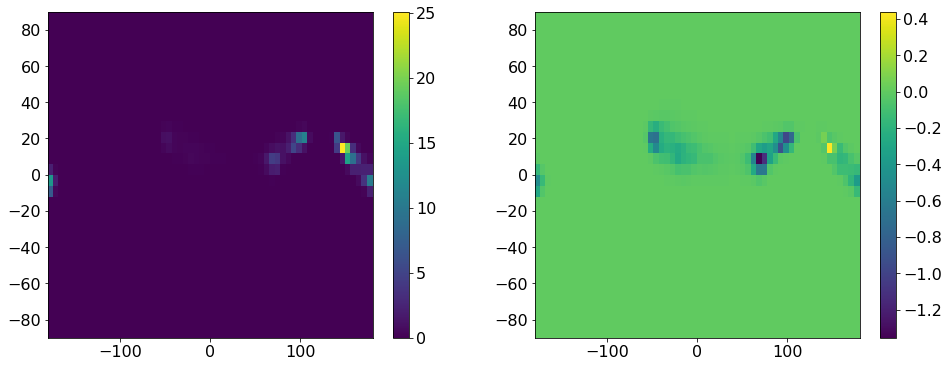

Convolving Delta image, iteration 87



Finding maximum acceleration parameter, iteration 87
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 88, numerator


Convolving Delta image, iteration 88



Finding maximum acceleration parameter, iteration 88
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 89, numerator


Convolving Delta image, iteration 89



Finding maximum acceleration parameter, iteration 89
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 90, numerator


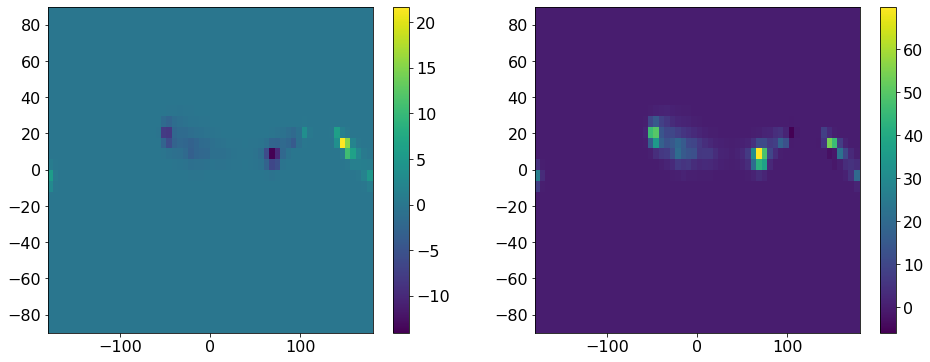

Convolving Delta image, iteration 90



Finding maximum acceleration parameter, iteration 90
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 91, numerator


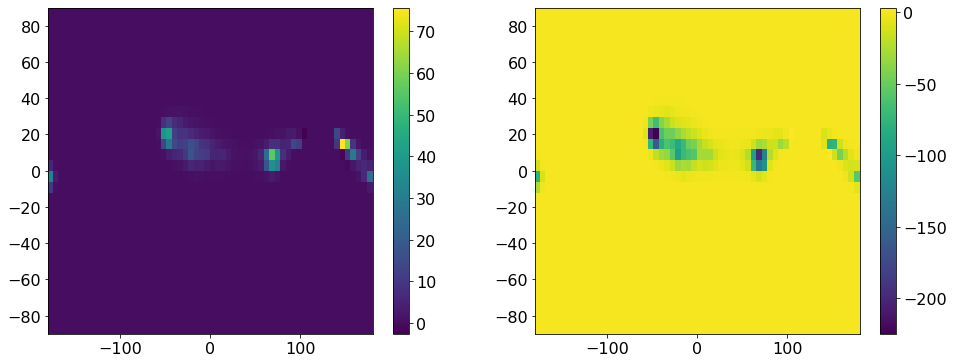

Convolving Delta image, iteration 91



Finding maximum acceleration parameter, iteration 91
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 92, numerator


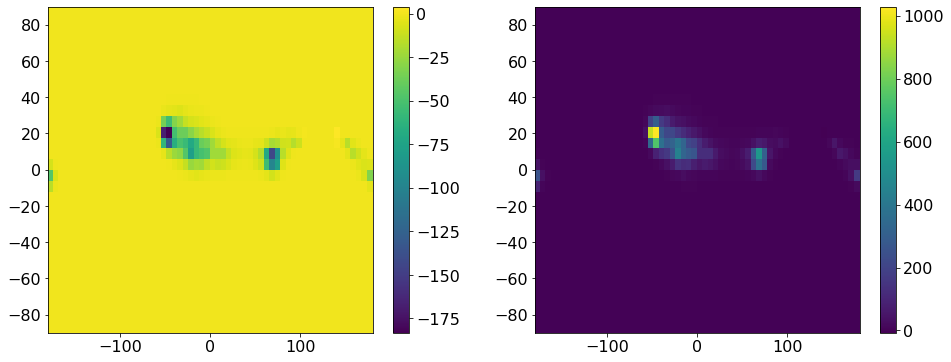

Convolving Delta image, iteration 92



Finding maximum acceleration parameter, iteration 92
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 93, numerator


Convolving Delta image, iteration 93



Finding maximum acceleration parameter, iteration 93
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 94, numerator


Convolving Delta image, iteration 94



Finding maximum acceleration parameter, iteration 94
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 95, numerator


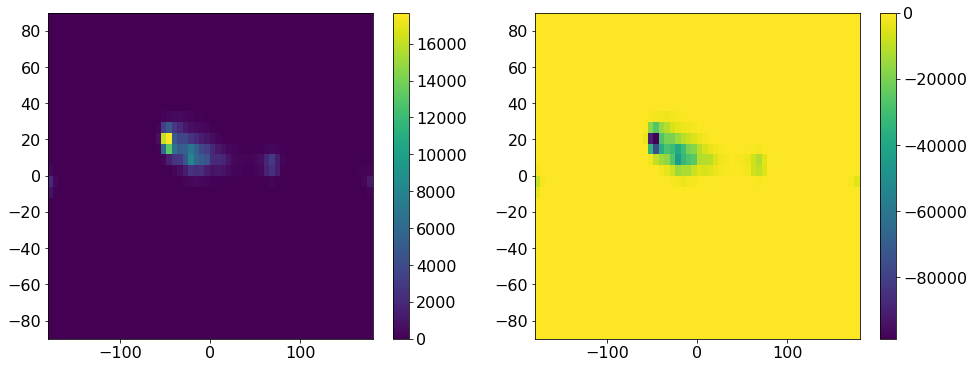

Convolving Delta image, iteration 95



Finding maximum acceleration parameter, iteration 95
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 96, numerator


Convolving Delta image, iteration 96



Finding maximum acceleration parameter, iteration 96
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 97, numerator


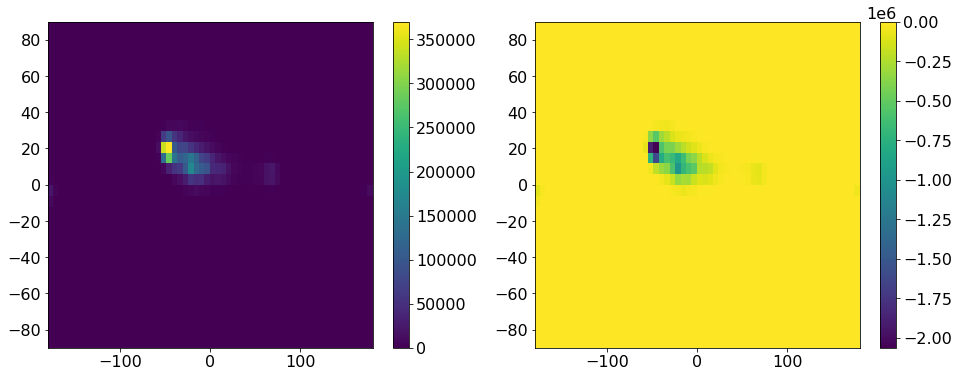

Convolving Delta image, iteration 97



Finding maximum acceleration parameter, iteration 97
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 98, numerator


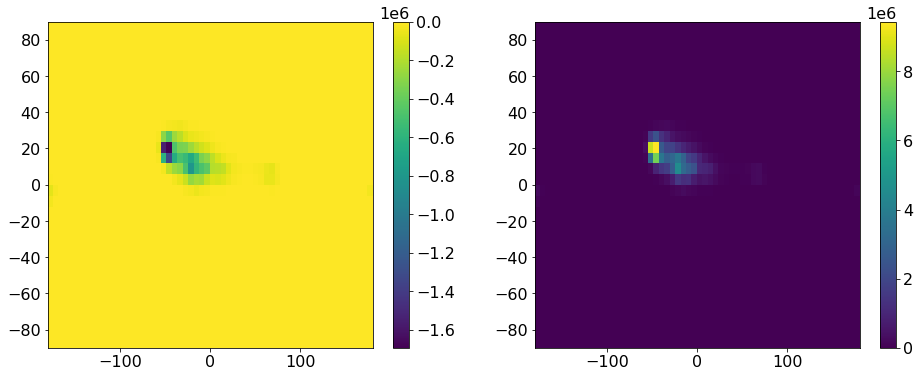

Convolving Delta image, iteration 98



Finding maximum acceleration parameter, iteration 98
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 99, numerator


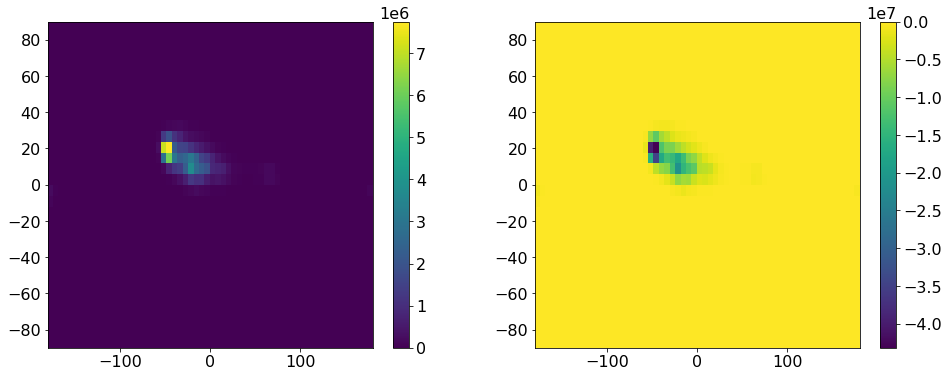

Convolving Delta image, iteration 99



Finding maximum acceleration parameter, iteration 99
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 100, numerator


Convolving Delta image, iteration 100



Finding maximum acceleration parameter, iteration 100
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 101, numerator


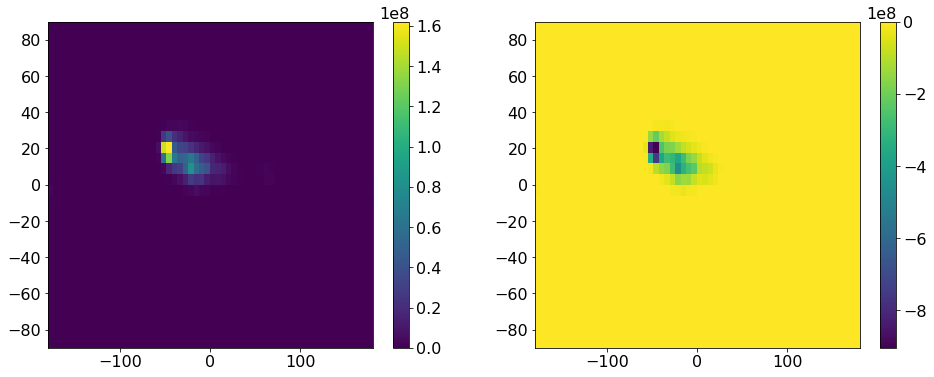

Convolving Delta image, iteration 101



Finding maximum acceleration parameter, iteration 101
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 102, numerator


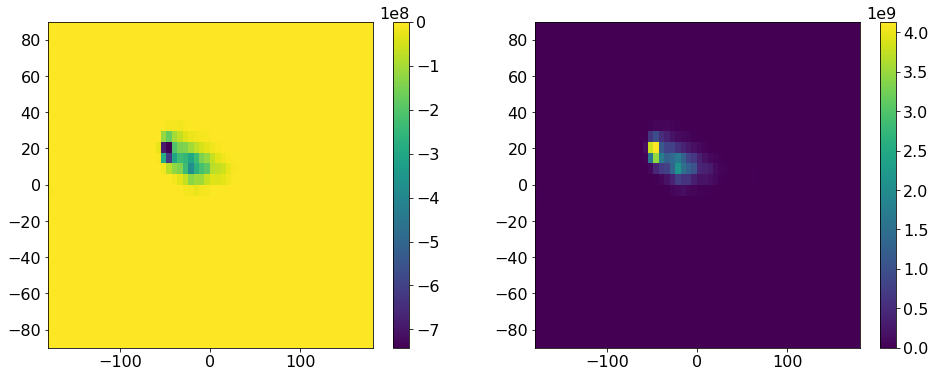

Convolving Delta image, iteration 102



Finding maximum acceleration parameter, iteration 102
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 103, numerator


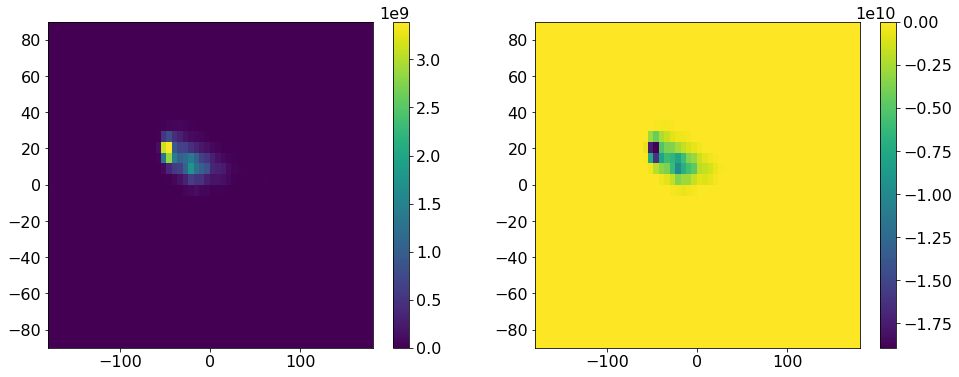

Convolving Delta image, iteration 103



Finding maximum acceleration parameter, iteration 103
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 104, numerator


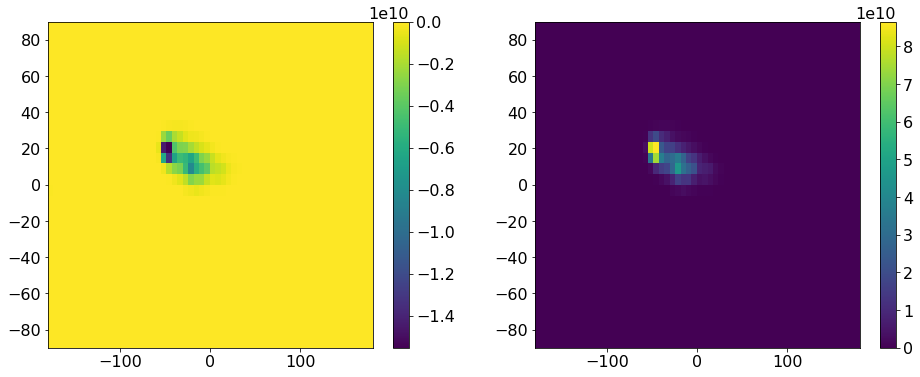

Convolving Delta image, iteration 104



Finding maximum acceleration parameter, iteration 104
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 105, numerator


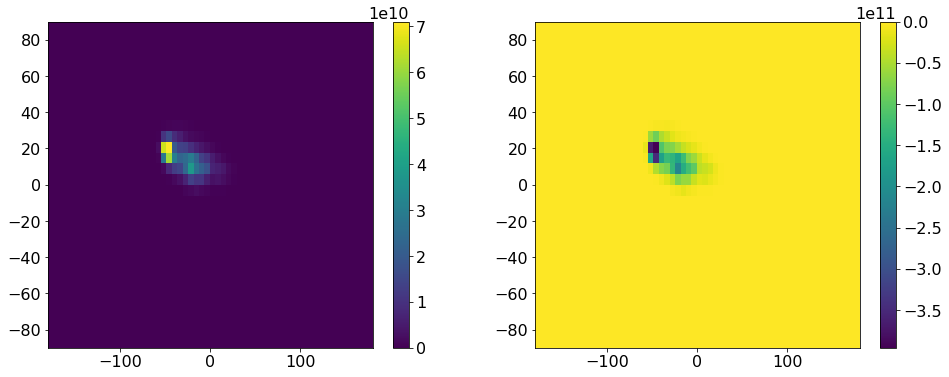

Convolving Delta image, iteration 105



Finding maximum acceleration parameter, iteration 105
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 106, numerator


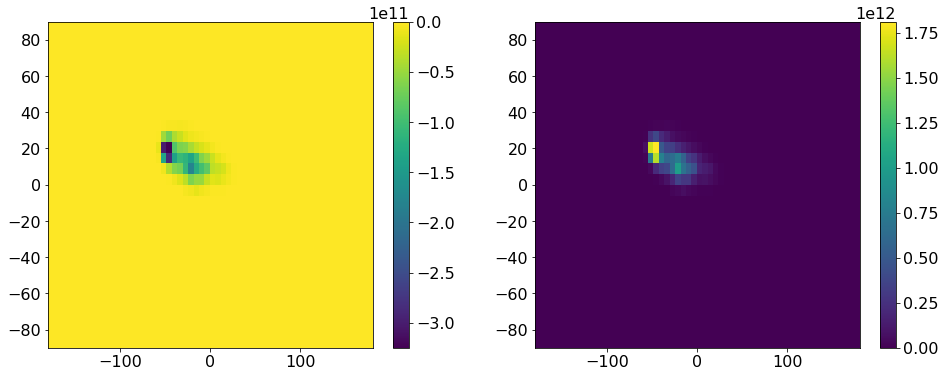

Convolving Delta image, iteration 106



Finding maximum acceleration parameter, iteration 106
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 107, numerator


Convolving Delta image, iteration 107



Finding maximum acceleration parameter, iteration 107
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 108, numerator


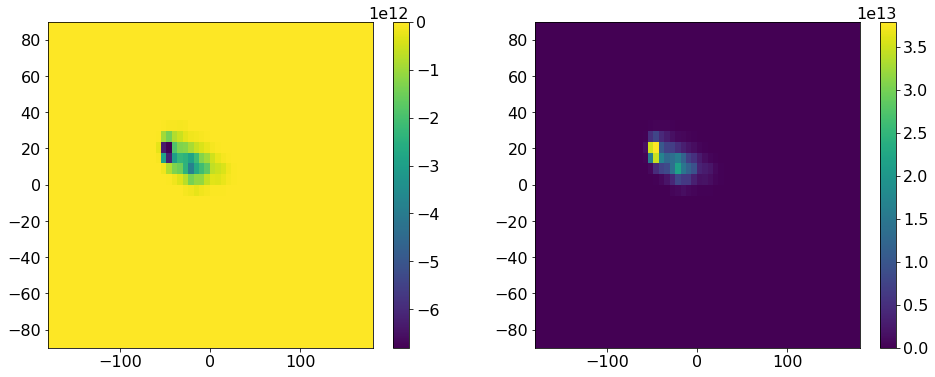

Convolving Delta image, iteration 108



Finding maximum acceleration parameter, iteration 108
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 109, numerator


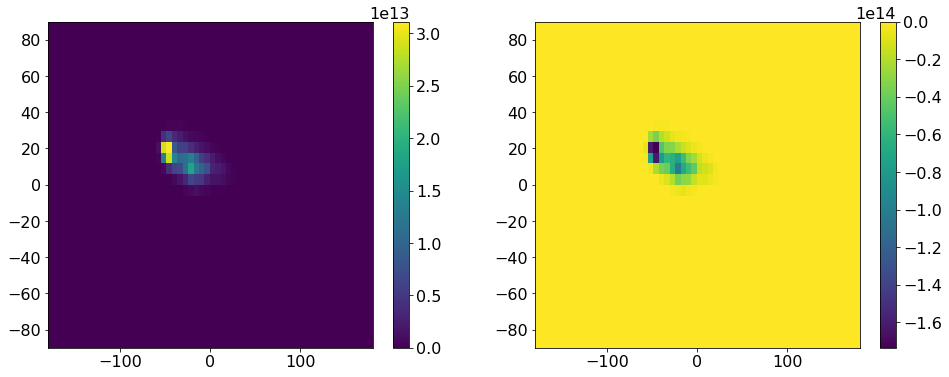

Convolving Delta image, iteration 109



Finding maximum acceleration parameter, iteration 109
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 110, numerator


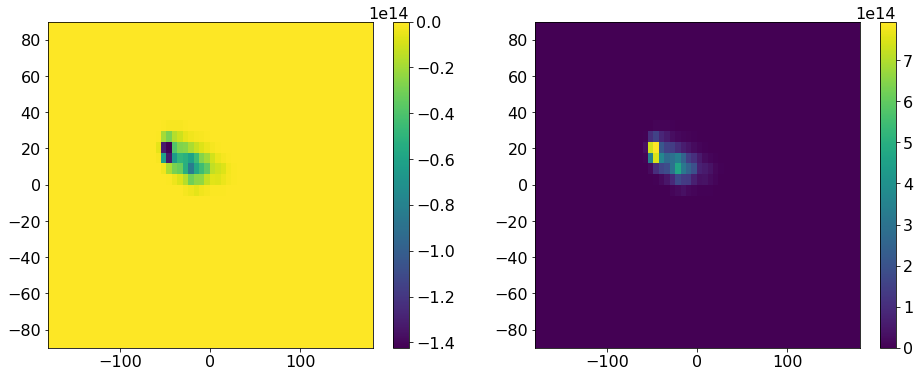

Convolving Delta image, iteration 110



Finding maximum acceleration parameter, iteration 110
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 111, numerator


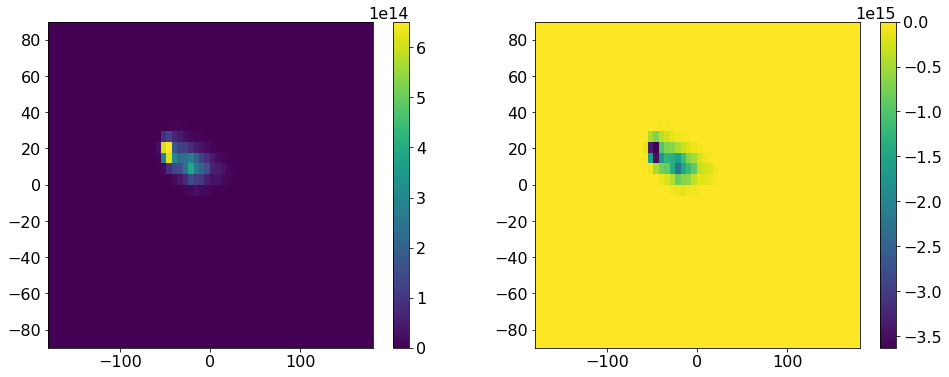

Convolving Delta image, iteration 111



Finding maximum acceleration parameter, iteration 111
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 112, numerator


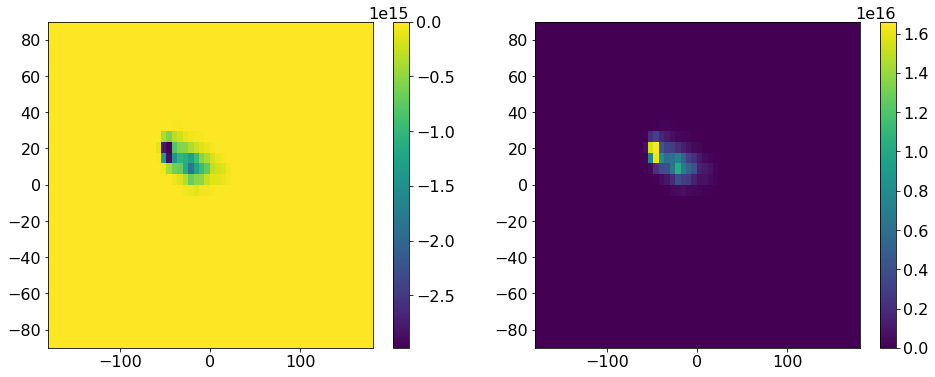

Convolving Delta image, iteration 112



Finding maximum acceleration parameter, iteration 112
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 113, numerator


Convolving Delta image, iteration 113



Finding maximum acceleration parameter, iteration 113
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 114, numerator


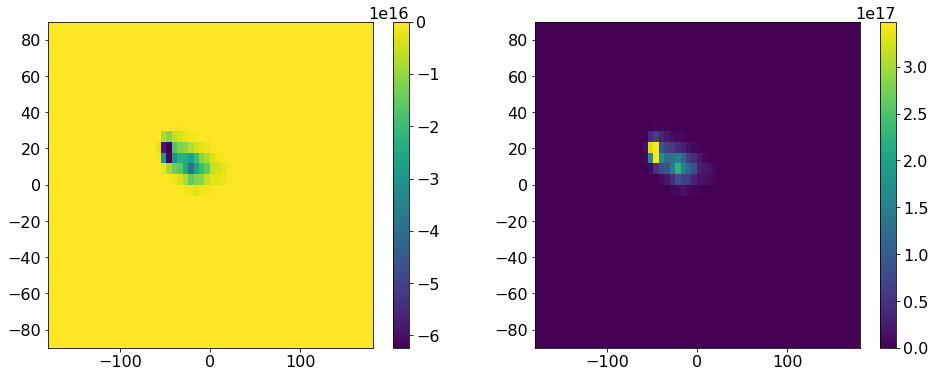

Convolving Delta image, iteration 114



Finding maximum acceleration parameter, iteration 114
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 115, numerator


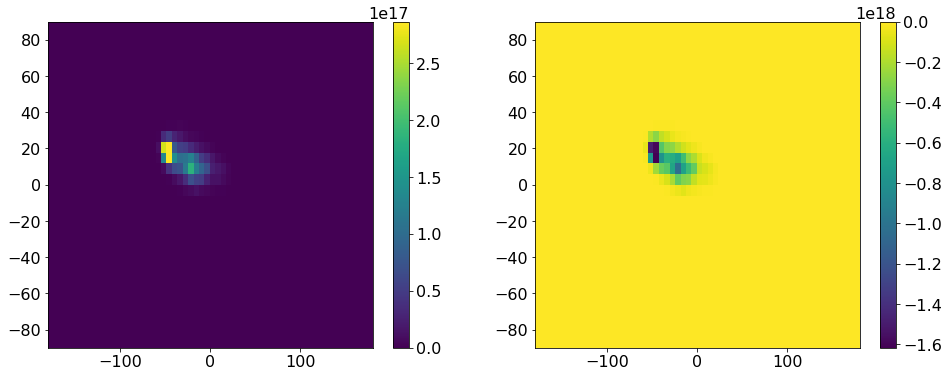

Convolving Delta image, iteration 115



Finding maximum acceleration parameter, iteration 115
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 116, numerator


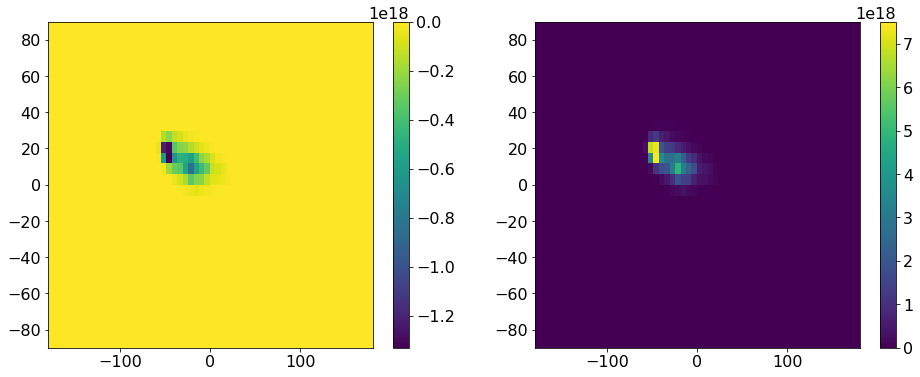

Convolving Delta image, iteration 116



Finding maximum acceleration parameter, iteration 116
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 117, numerator


Convolving Delta image, iteration 117



Finding maximum acceleration parameter, iteration 117
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 118, numerator


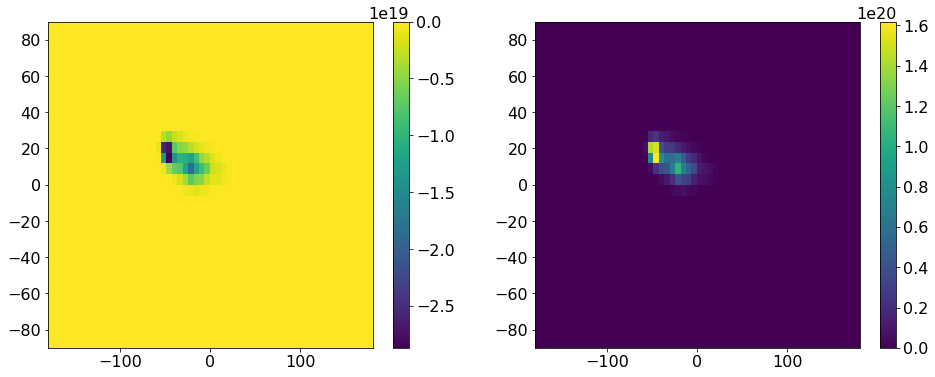

Convolving Delta image, iteration 118



Finding maximum acceleration parameter, iteration 118
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 119, numerator


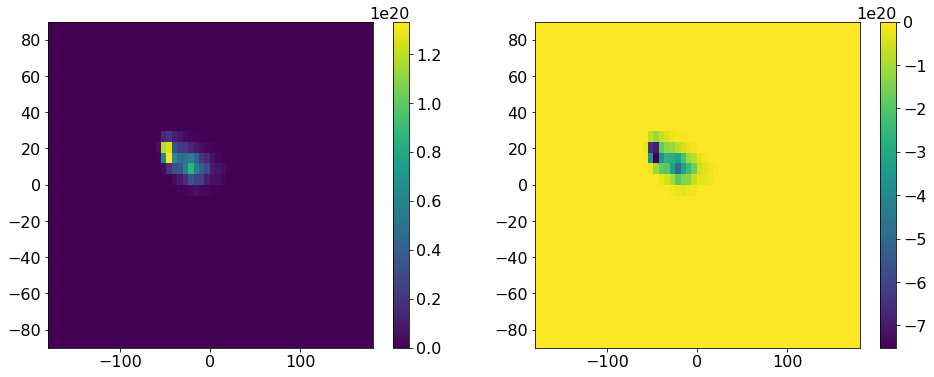

Convolving Delta image, iteration 119



Finding maximum acceleration parameter, iteration 119
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 120, numerator


Convolving Delta image, iteration 120



Finding maximum acceleration parameter, iteration 120
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 121, numerator


Convolving Delta image, iteration 121



Finding maximum acceleration parameter, iteration 121
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 122, numerator


Convolving Delta image, iteration 122



Finding maximum acceleration parameter, iteration 122
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 123, numerator


Convolving Delta image, iteration 123



Finding maximum acceleration parameter, iteration 123
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 124, numerator


Convolving Delta image, iteration 124



Finding maximum acceleration parameter, iteration 124
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 125, numerator


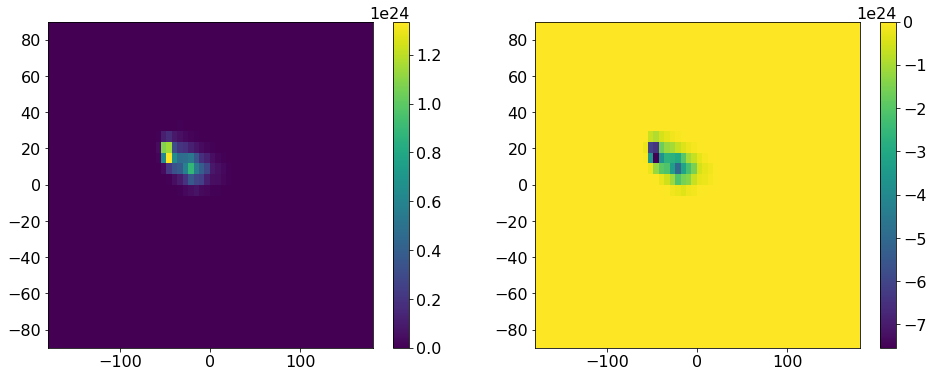

Convolving Delta image, iteration 125



Finding maximum acceleration parameter, iteration 125
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 126, numerator


Convolving Delta image, iteration 126



Finding maximum acceleration parameter, iteration 126
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 127, numerator


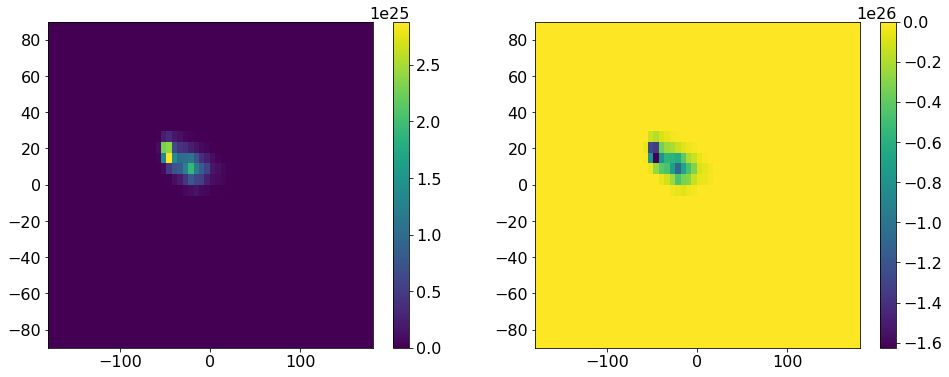

Convolving Delta image, iteration 127



Finding maximum acceleration parameter, iteration 127
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 128, numerator


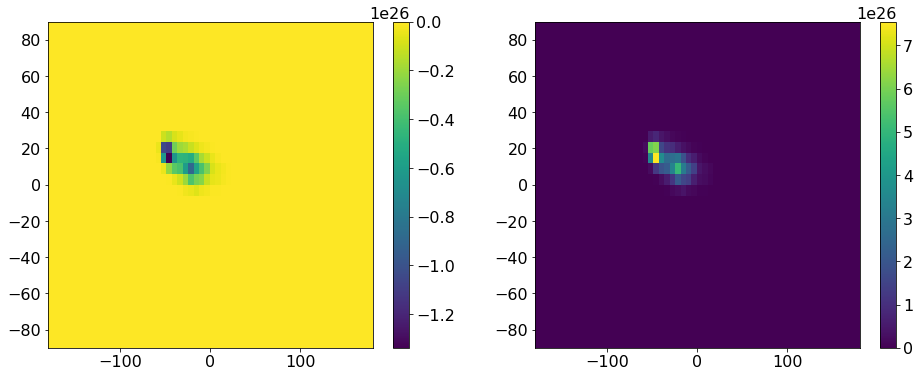

Convolving Delta image, iteration 128



Finding maximum acceleration parameter, iteration 128
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 129, numerator


Convolving Delta image, iteration 129



Finding maximum acceleration parameter, iteration 129
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 130, numerator


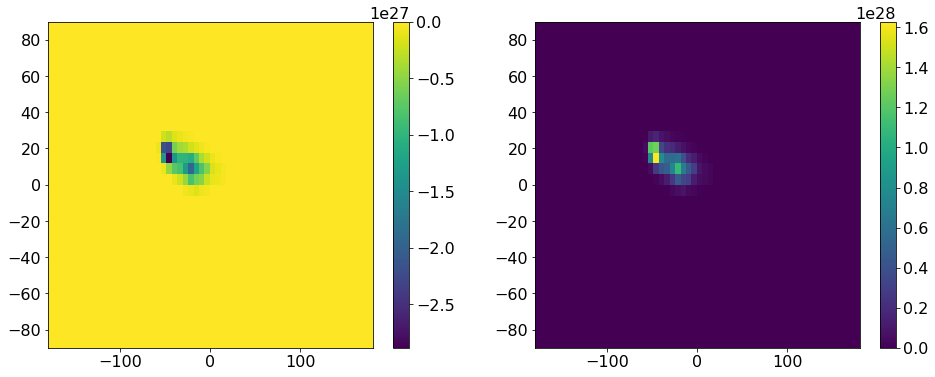

Convolving Delta image, iteration 130



Finding maximum acceleration parameter, iteration 130
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 131, numerator


Convolving Delta image, iteration 131



Finding maximum acceleration parameter, iteration 131
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 132, numerator


Convolving Delta image, iteration 132



Finding maximum acceleration parameter, iteration 132
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 133, numerator


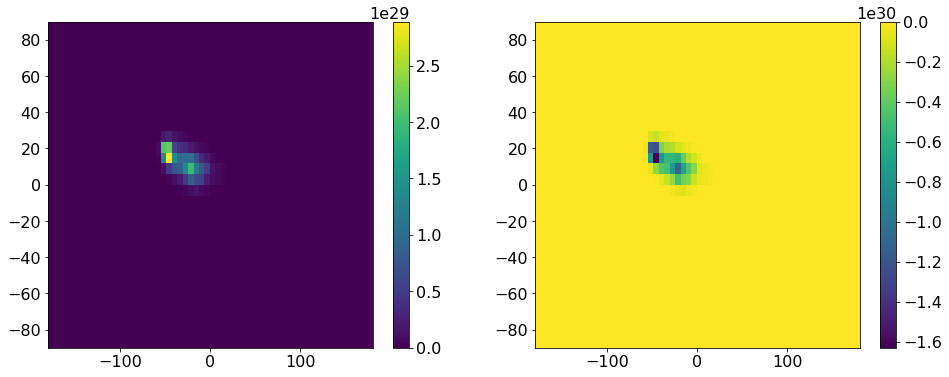

Convolving Delta image, iteration 133



Finding maximum acceleration parameter, iteration 133
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 134, numerator


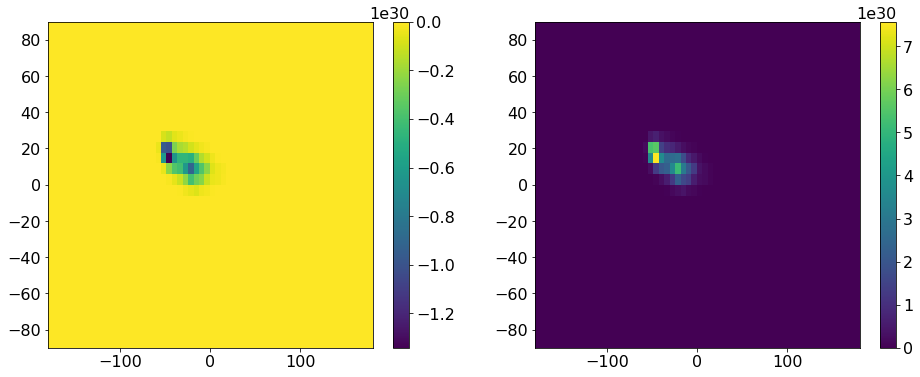

Convolving Delta image, iteration 134



Finding maximum acceleration parameter, iteration 134
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 135, numerator


Convolving Delta image, iteration 135



Finding maximum acceleration parameter, iteration 135
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 136, numerator


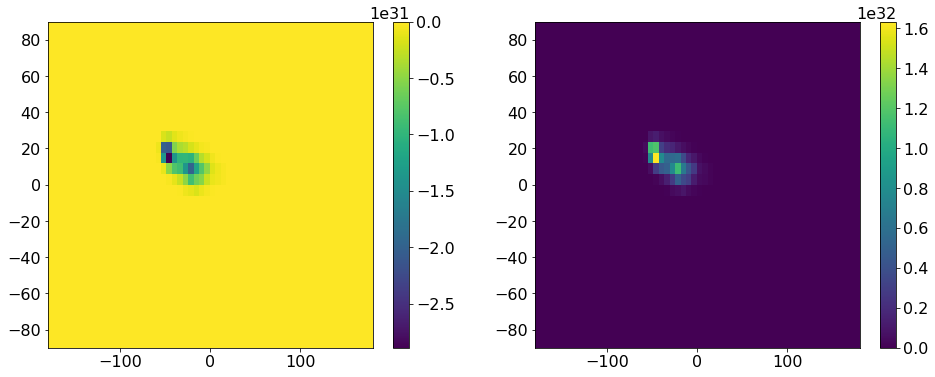

Convolving Delta image, iteration 136



Finding maximum acceleration parameter, iteration 136
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 137, numerator


Convolving Delta image, iteration 137



Finding maximum acceleration parameter, iteration 137
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 138, numerator


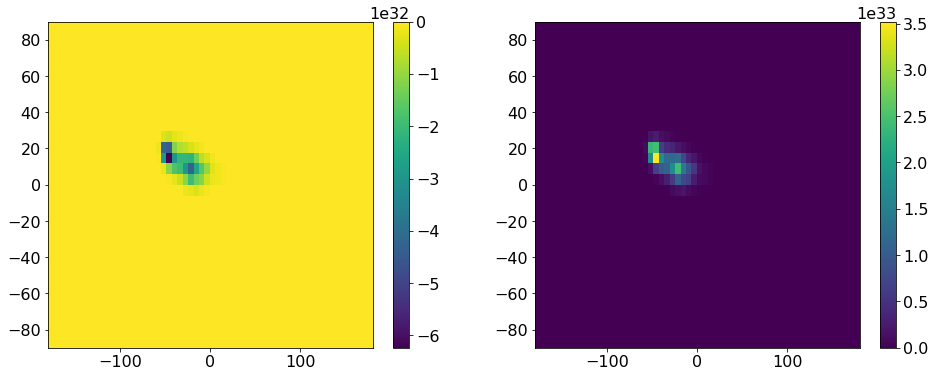

Convolving Delta image, iteration 138



Finding maximum acceleration parameter, iteration 138
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 139, numerator


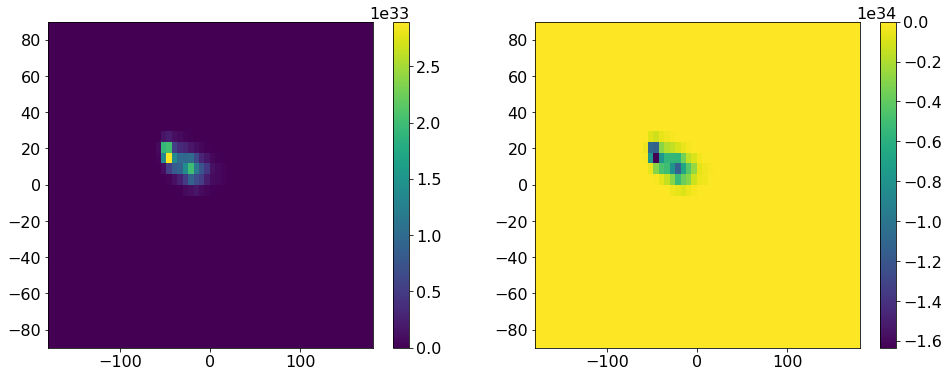

Convolving Delta image, iteration 139



Finding maximum acceleration parameter, iteration 139
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 140, numerator


Convolving Delta image, iteration 140



Finding maximum acceleration parameter, iteration 140
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 141, numerator


Convolving Delta image, iteration 141



Finding maximum acceleration parameter, iteration 141
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 142, numerator


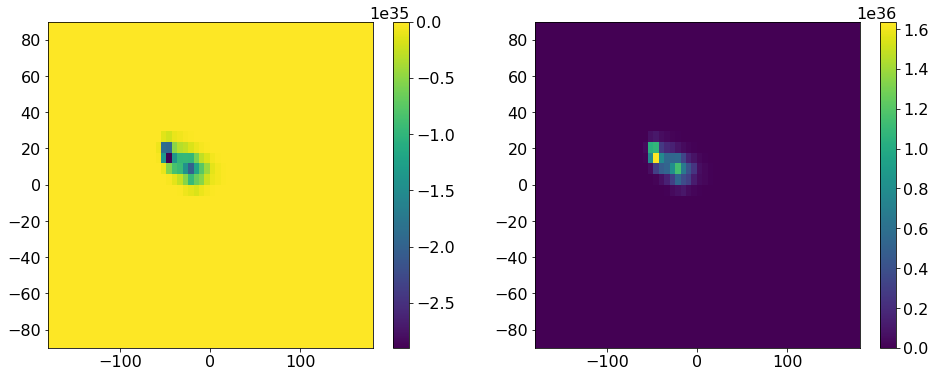

Convolving Delta image, iteration 142



Finding maximum acceleration parameter, iteration 142
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 143, numerator


Convolving Delta image, iteration 143



Finding maximum acceleration parameter, iteration 143
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 144, numerator


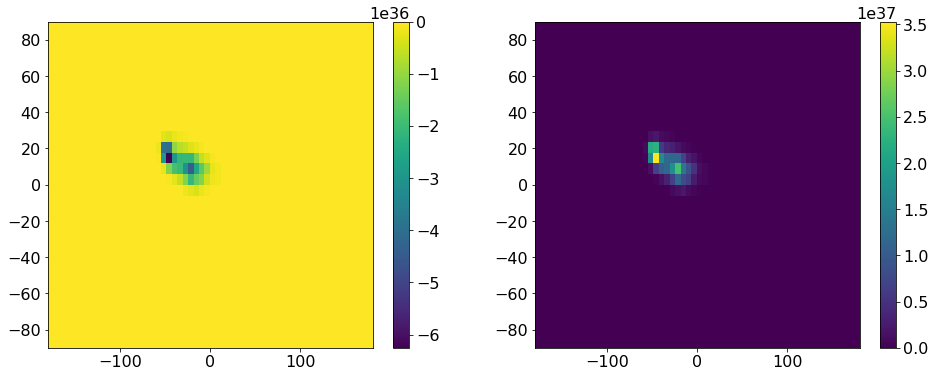

Convolving Delta image, iteration 144



Finding maximum acceleration parameter, iteration 144
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 145, numerator


Convolving Delta image, iteration 145



Finding maximum acceleration parameter, iteration 145
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 146, numerator


Convolving Delta image, iteration 146



Finding maximum acceleration parameter, iteration 146
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 147, numerator


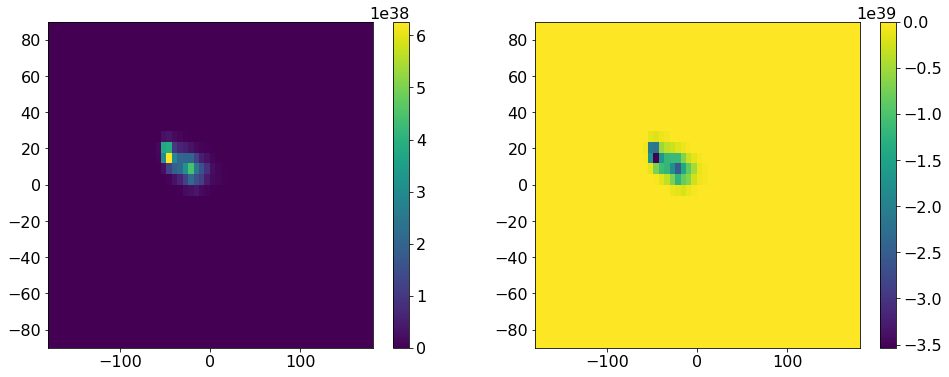

Convolving Delta image, iteration 147



Finding maximum acceleration parameter, iteration 147
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 148, numerator


Convolving Delta image, iteration 148



Finding maximum acceleration parameter, iteration 148
############## Fit failed! proceeding without acceleration ##############
Calculating Delta image, iteration 149, numerator


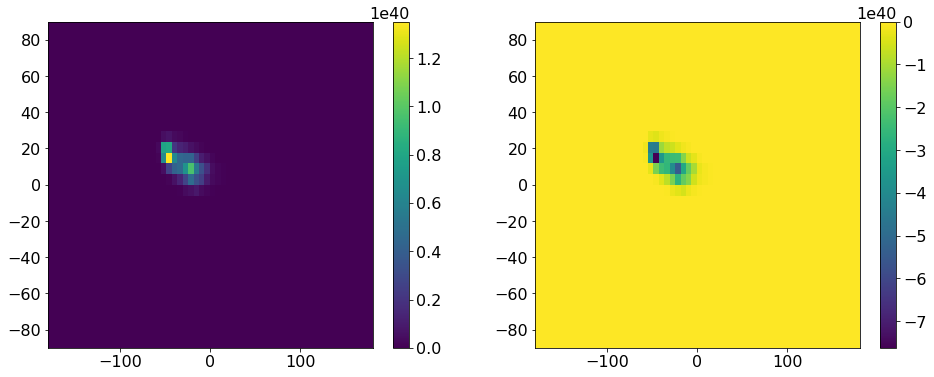

Convolving Delta image, iteration 149



Finding maximum acceleration parameter, iteration 149
############## Fit failed! proceeding without acceleration ##############

Initial log joint probability = -169707
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: poisson_lpmf: Rate parameter[1] is -6.19899e-05, but must be >= 0!  (in 'fit_COSI_conved_2D_multimap_indivBG.stan' at line 76)

Exception: poisson_lpmf: Rate parameter[1] is -5.44288e-05, but must be >= 0!  (in 'fit_COSI_conved_2D_multimap_indivBG.stan' at line 76)

Exception: poisson_lpmf: Rate parameter[1] is -4.30123e-05, but must be >= 0!  (in 'fit_COSI_conved_2D_multimap_indivBG.stan' at line 76)

Exception: poisson_lpmf: Rate parameter[1] is -2.14185e-05, but must be >= 0!  (in 'fit_COSI_conved_2D_multimap_indivBG.stan' at line 76)

Exception: poisson_lpmf: Rate parameter[25323] is -6.08984e-07, but must be >= 0!  (in 'fit_COSI_conved_2D_multimap_indivBG.stan' at line 76)


      19       -166611      0.680059  

In [83]:
# initial map (isotropic flat, small value)
#map_init = IsoMap(L_ARR,B_ARR,1)
map_init = IsoMap(L_ARR, B_ARR, 1.0)

# other initial conditions (not needed here)
#map_init = five11keV_map_240mu*n_days
#map_init[bad_expo[0],bad_expo[1]] = 0

# define background (to be sure it's the same as before)
bg_cuts, idx_arr, Ncuts = background1.bg_cuts, background1.idx_arr, background1.Ncuts

# number of RL iterations 
iterations = 150

# that's a scalling factor for the 'Delta map', allowing it to be 1000
# times stronger than the original RL algorithm suggests (cf Knoedlseder+1997)
afl_scl = 1000.

## Save intermediate iterations:
# initialise arrays to save images and other parameters to
# maps per iteration
map_iterations = np.zeros((n_b, n_l, iterations))
# likelihood of maps (vs. initial i.e. basically only background)
map_likelihoods = np.zeros(iterations)
# fit likelihoods, ie fit quality
intermediate_lp = np.zeros(iterations)
# acceleration parameters (lambda)
acc_par = np.zeros(iterations)
# fitted background parameters 
bg_pars = np.zeros((iterations,Ncuts))

# as zeroth iteration, copy initial map to become the 'old map' (see below)
map_old = map_init

# cf. Knoedlseder+1997 what the values denominator etc are
# this is the response R summed over the CDS and the time bins
denominator = expo_map

# zeroth iteration is then just the initial map
map_iterations[:,:,0] = map_old#[]

# convolve this map with the response
expectation_init = 0
print('Convolving with response (init expectation), iteration 0')
for i in tqdm(range(n_b)):
    for j in range(n_l):
        expectation_init += sky_response_scaled[:,i,j,:]*map_init[i,j]

# set old expectation (in data space bins) to new expectation (convolved image)
expectation_old = expectation_init

### now we have the expectation of the image. Need to go to the BG 
        
###########################################################
###########################################################
## here run over the number of iterations #################
###########################################################
## the time for the convolutions is very large ############
## this can be 10 minutes (!) per iteration ###############
## this should be tested for a few iterations #############
## and then run over night or similar #####################
###########################################################
###########################################################
for its in tqdm(range(1,iterations)):
    
    # setting the map to zero where we selected a bad exposure (we didn't, but to keep it general)
    map_old[bad_expo[0],bad_expo[1]] = 0
    # check for each pixel to be finite
    map_old[np.where(np.isnan(map_old) == True)] = 0
    
    # make new background for the next iteration
    bg_cuts, idx_arr, Ncuts = background1.bg_cuts, background1.idx_arr, background1.Ncuts
    
    # temporary background model
    tmp_model_bg = np.zeros((d2h,background1.bg_model_reduced[ebin].shape[1]))
    
    # there could be something different for the first iteration (here it isn't, same function call)
    if its == 1:
        for g in range(d2h):
            tmp_model_bg[g,:] = background_model[g,:]*fitted_bg[idx_arr-1][g]
    else:
        for g in range(d2h):
            tmp_model_bg[g,:] = background_model[g,:]*fitted_bg[idx_arr-1][g]
            
    # expectation (in data space) is the image (expectation_old) plus the background (tmp_model_bg)
    expectation_tot_old = expectation_old + tmp_model_bg 

    # calculate likelihood of currect total expectation
    map_likelihoods[its-1] = cashstat(dataset.ravel(),expectation_tot_old.ravel())
    
    # calculate numerator of RL algorithm
    numerator = 0
    print('Calculating Delta image, iteration '+str(its)+', numerator')
    for i in tqdm(range(d2h)):
        for j in range(dataset.shape[1]):
            numerator += (dataset[i,j]/expectation_tot_old[i,j]-1)*sky_response_scaled[i,:,:,j]
            # denominator could be different (not the case here)
            #denominator += (sky_response_scaled[i,:,:,j]**2/expectation_tot_old[i,j])
    
    # calculate delta map (denominator scaled by fourth root to avoid exposure edge effects)
    delta_map_tot_old = (numerator/denominator)*map_old*(denominator)**0.25
#    delta_map_tot_old = (numerator/denominator)*map_old*(denominator)**0
#    delta_map_tot_old = (numerator/denominator)*map_old*(denominator)**0.5
    
    
    # alternatively, could smooth it (not used here)
#     delta_map_tot_old = smooth((numerator/denominator)*map_old*np.sqrt(denominator), 0.5)    
#    delta_map_tot_old = gaussian_filter(delta_map_tot_old, 0.5)
    
    #################################
    
    
    
    # check again for finite values and zero our bad exposure regions
    nan_idx = np.where(np.isnan(delta_map_tot_old) == 1)
    delta_map_tot_old[nan_idx[0],nan_idx[1]] = 0
    delta_map_tot_old[bad_expo[0],bad_expo[1]] = 0

    # the plots are not required, but I like to see how the algorithm is doing
    # so that I could stop prematurely when the image isnt changing any more
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.pcolormesh(L_ARRg,B_ARRg,np.roll(map_old, axis=1, shift=0)) # use np.flip(map_old, axis=1)?
    plt.colorbar()

    plt.subplot(122)
    plt.pcolormesh(L_ARRg,B_ARRg,np.roll(delta_map_tot_old, axis=1, shift=0)) # use np.flip(map_old, axis=1)?
    plt.colorbar()
    plt.show()
    
    # convolve delta image
    print('Convolving Delta image, iteration '+str(its))
    conv_delta_map_tot = 0
    for i in tqdm(range(n_b)):
        for j in range(n_l):
            conv_delta_map_tot += sky_response_scaled[:,i,j,:]*delta_map_tot_old[i,j]
    
    # find maximum acceleration parameter to multiply delta image with
    # so that the total image is still positive everywhere
    print('Finding maximum acceleration parameter, iteration '+str(its))
    try:
        len_arr = []
        for i in range(0,10000):
            len_arr.append(len(np.where((map_old+delta_map_tot_old*i/afl_scl) < 0)[0]))
        len_arr = np.array(len_arr)
        afl = np.max(np.where(len_arr == 0)[0])
        print('Maximum acceleration parameter found: ',afl/afl_scl)

        
        # fit delta map and current map to speed up RL algorithm
        print('Fitting delta-map in addition to old map, iteration '+str(its))
        # dictionary for data set and prior
        # note that here the value for N should be your response CDS dimension
        # should be last dimension of the scaled response thing (change to your value)
        data_multimap = dict(N = dataset.shape[1],
                     Nh = d2h,
                     Ncuts = Ncuts,
                     Nsky = 2,
                     acceleration_factor_limit=afl*0.95,
                     bg_cuts = bg_cuts,
                     bg_idx_arr = idx_arr,
                     y = dataset.ravel().astype(int),
                     bg_model = tmp_model_bg,
                     conv_sky = np.concatenate([[expectation_old],[conv_delta_map_tot/afl_scl]]),
#                      mu_flux = np.array([1,afl/2]),     # thomas' default
#                      sigma_flux = np.array([1e-2,afl]), # thomas' default
                     mu_flux = np.array([1,afl/2]),
                     sigma_flux = np.array([1e-2,afl]),
                     mu_Abg = fitted_bg,
                     sigma_Abg = fitted_bg)#/10.))#[0.2]))#0.2 #np.repeat(0.1,Ncuts))

        # fit;
        # i tested something here, but doesn't matter
        #fitBG = modelBG.sampling(data=data2D,chains=1,iter=1000,n_jobs=-1,pars=['Abg'])# only 1 chain because it kills my RAM otherwise
        # initial values for fit (somewhat sensitive here with COSI data)
        init = {}
        init['flux'] = np.array([1.,afl/2.])
        init['Abg'] = np.repeat(fitted_bg, Ncuts)#np.repeat(0.99,Ncuts)
        # fit: might take some time but it shouldn't be more than a minute
        op2D = model_multimap.optimizing(data=data_multimap,init=init,as_vector=False,verbose=True,
                                                tol_rel_grad=1e3,tol_obj=1e-20)

        # save values
        print('Saving new map, and fitted parameters, iteration '+str(its))
        intermediate_lp[its-1] = op2D['value']
        acc_par[its-1] = op2D['par']['flux'][1]
        bg_pars[its-1,:] = op2D['par']['Abg']
  
        # make new map as old map plus scaled delta map
        map_new = map_old+op2D['par']['flux'][1]*delta_map_tot_old/afl_scl
    
        # same with expectation (data space)
        expectation_new = expectation_old + op2D['par']['flux'][1]*conv_delta_map_tot/afl_scl
        
        # that's an alternative way, not used here
        """N_t = 25
        cstat_arr = np.zeros((N_t*4,N_t))
        bg_arr = np.linspace(0.95,1.1,N_t*4)
        lambda_arr = np.linspace(afl_scl,afl,N_t)

        for i in tqdm(range(N_t*4)):
            for j in range(N_t):
                cstat_arr[i,j] = cashstat(dataset.ravel().astype(int),
                                          background_model.ravel()*n_days*bg_arr[i] +\
                                          expectation_old.ravel() +\
                                          conv_delta_map_tot.ravel()/afl_scl*lambda_arr[j])
                
        intermediate_min = np.where(minmin(cstat_arr) == 0)

        print('Saving new map, and fitted parameters, iteration '+str(its))
        print('intermediate minimum bg, lambda: ',bg_arr[intermediate_min[0][0]],lambda_arr[intermediate_min[1][0]]/afl_scl)
        acc_par[its-1] = lambda_arr[intermediate_min[1][0]]#op2D['par']['flux'][1]
        bg_pars[its-1,:] = bg_arr[intermediate_min[0][0]]#op2D['par']['Abg']

        map_new = map_old + lambda_arr[intermediate_min[1][0]]*delta_map_tot_old/afl_scl"""

    except:
        # if the fit failed...
        # this shouldn't happen too often (or at all)
        print('############## Fit failed! proceeding without acceleration ##############')
        map_new = map_old + delta_map_tot_old
        expectation_new = expectation_old + conv_delta_map_tot
        #map_new = map_old + np.random.rand(expo_map.shape[0],expo_map.shape[1])*np.median(map_old)*0.001
        
    #map_new[bad_expo[0],bad_expo[1]] = 0
    
    # check finite values again
    if its == 1:
        bad_index_init = np.where(np.isnan(map_new) == True)
    
    # also here
    map_new[bad_expo[0],bad_expo[1]] = 0
    map_new[np.where(np.isnan(map_new) == True)] = 0
    map_iterations[:,:,its] = map_new

    # swap maps
    map_old = map_new
    
    # and expectations
    expectation_old = expectation_new
    
    
    # and repeat




In [84]:
its

149

## Plot bg params and flux

In [85]:
iterations

150

Text(0, 0.5, 'Flux')

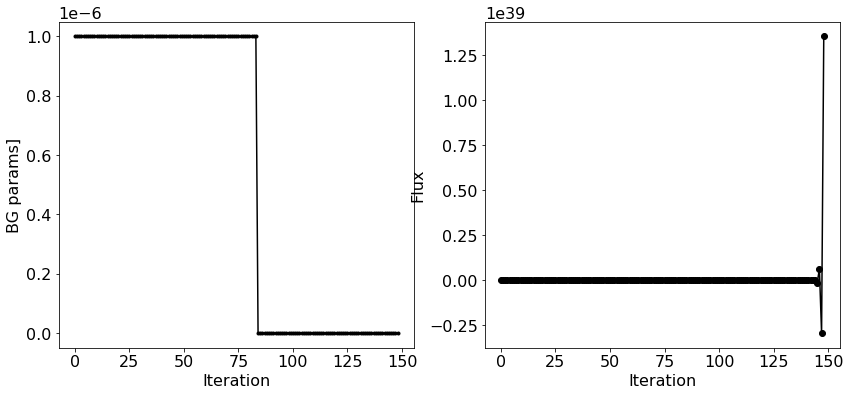

In [86]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(range(its), [i[0] for i in bg_pars[:its]], '.-')
#plt.plot(range(12), [i[0] for i in bg_pars[:12]], '.-')
plt.xlabel('Iteration')
plt.ylabel('BG params]')


plt.subplot(122)
map_fluxes = np.zeros(its)
for i in range(its):
    map_fluxes[i] = np.sum(map_iterations[:,:,i]*domega)
    
plt.plot(map_fluxes[:its],'o-')
#plt.plot(map_fluxes[:12],'o-')
plt.xlabel('Iteration')
plt.ylabel('Flux')# [ph/keV]')

Text(0, 0.5, 'likelihood (map_likelihoods)')

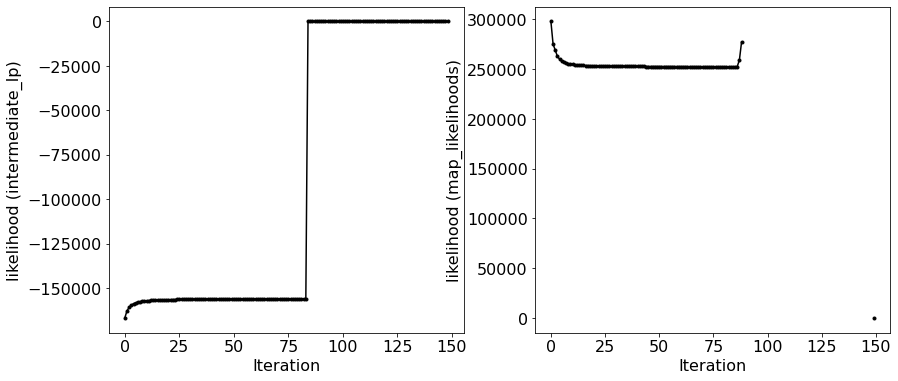

In [87]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(range(its+1)[:-1], intermediate_lp[:its+1][:-1], '.-')
#plt.plot(range(12), intermediate_lp[:12], '.-')
plt.xlabel('Iteration')
plt.ylabel('likelihood (intermediate_lp)')

plt.subplot(122)
plt.plot(range(its+1), map_likelihoods[:its+1], '.-')
#plt.plot(range(12), map_likelihoods[:12], '.-')
plt.xlabel('Iteration')
plt.ylabel('likelihood (map_likelihoods)')

## convolve the final image to CDS x time, sum over the CDS to get the time profile, then compare that to the dataset lightcurve

In [88]:
sky_response_scaled.shape

(2232, 30, 60, 2295)

In [89]:
final_idx = 84#its
final_image = np.roll(map_iterations[:,:,final_idx],axis=1,shift=0)
final_image.shape

(30, 60)

In [90]:
# conv_map = 0
# for i in tqdm(range(n_b)):
#     for j in range(n_l):
#         if np.isfinite(final_image[i,j]) == True:
#             conv_map += sky_response_scaled[:,i,j,:]*final_image[i, j]

In [91]:
# conv_map.shape

In [92]:
# plt.plot(np.sum(conv_map,axis=1),label='conv pixel lookup')
# #plt.plot(analysis1_binned,label='dirbe simulation')
# plt.plot(np.sum(rsp.sky_response[ebin],axis=1)*np.sum(conv_map),'b',label='PS response lookup')

# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('Expected counts')

In [93]:
from IPython.display import Image

from IPython.display import Video

from tqdm.autonotebook import tqdm

from matplotlib import animation

from matplotlib import colors

In [94]:
from scipy.ndimage import gaussian_filter as smooth

In [95]:
pixel_size

6.0

In [96]:
map_iterations.shape

(30, 60, 150)

In [97]:
print(map_iterations[:,:,final_idx].shape)

(30, 60)


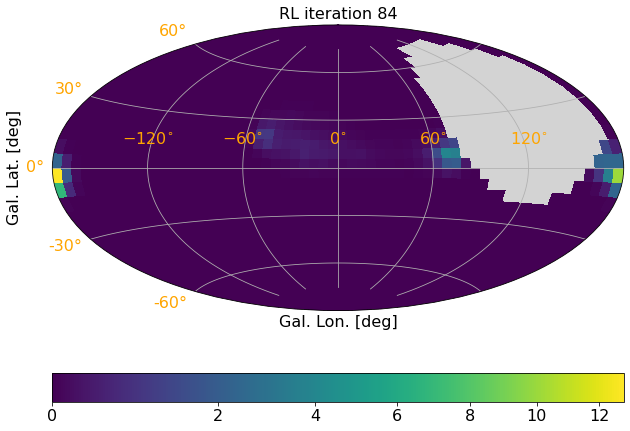

In [109]:
cmap = plt.get_cmap('viridis') #nipy_spectral, twilight_shifted, viridis
# bad exposures will be gray
cmap.set_bad('lightgray')


##################
# select here which pixels should be gray
map_iterations_nan = np.copy(map_iterations)
# I select also non-zero exposures here to be gray (avoiding the edge effects)
#bad_expo = np.where(expo_map/domega <= 1e4)
bad_expo = np.where(expo_map/domega <= 1e4) # <= 0
for i in range(iterations):
    map_iterations_nan[bad_expo[0], bad_expo[1], i] = np.nan
#################    


# plotting for video
fig, ax = plt.subplots(figsize=(10.24,7.68),subplot_kw={'projection':'aitoff'},nrows=1,ncols=1)

ax.set_xticks(np.array([-120,-60,0,60,120])*deg2rad)
ax.tick_params(axis='x', colors='orange')
ax.set_xticklabels([r'$-120^{\circ}$'+'\n',
                            r'$-60^{\circ}$'+'\n',
                            r'$0^{\circ}$'+'\n',
                            r'$60^{\circ}$'+'\n',
                            r'$120^{\circ}$'+'\n'])
ax.set_yticks(np.array([-60,-30,0,30,60])*deg2rad)
ax.tick_params(axis='y', colors='orange')


plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')
#ax.grid()


# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame

from matplotlib.colors import LogNorm

ims = []
for i in [final_idx]:#[iterations-1]:
#for i in range(iterations):
    ttl = plt.text(0.5, 1.01, r'RL iteration {0:1.0f}'.format(i), horizontalalignment='center', 
                   verticalalignment='bottom', transform=ax.transAxes)
        
    img = ax.pcolormesh(L_ARRg*deg2rad,B_ARRg*deg2rad,
                        
                        ## no masking of exposure
                        #np.roll(map_iterations[:,:,i],axis=1,shift=0),
                    
                        ## mask out bad exposure
                        np.roll(map_iterations_nan[:,:,i],axis=1,shift=0),
                        
                        ## smooth with gaussian filter
                        #smooth(np.roll(map_iterations_nan[:,:,i],axis=1,shift=0), .75/pixel_size),
                        
                        #cmap=plt.cm.nipy_spectral,
                        #cmap=plt.cm.gist_earth,
                        cmap=plt.cm.viridis,
                        
                        #norm=LogNorm(vmin=1E-3, vmax=np.roll(map_iterations[:,:,i],axis=1,shift=0).max()),
                        norm=colors.PowerNorm(0.6667),
                        #
                        #vmax=1
                       )
    
    ims.append([img,
                #ax.scatter(np.deg2rad(fov[0])-np.pi,np.deg2rad(fov[1]),color='red',marker='.',s=0.5),
                #ax.scatter(np.deg2rad(fov2[0])+np.pi-np.pi,np.deg2rad(fov[1]),color='red',marker='.',s=0.5),
                #ax.scatter(np.deg2rad(l1-180),np.deg2rad(b1),color='red',marker='o',s=40),
                ttl])

cbar = fig.colorbar(img, orientation='horizontal')
#cbar.ax.set_xlabel(r'Flux [10$^{-2}$ ph cm$^{-2}$ s$^{-1}$]')
    
ax.grid()


#plt.savefig(data_dir+'images/DC_Al2610xFlux_Ling_6deg_DeltaT960s.pdf', bbox_inches='tight')
    
#ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=0)
#ani.save(data_dir+'images/RLstandard_1809keV_AsymmGauss_step6deg_ori_star_flux2e-1_dT1000s_noBG_75iters_PowerNorm0.3.gif')

In [91]:
# fit a 2D Gaussian to the emission

In [181]:
def gauss_2d(xtuple, A, x0, y0, sigma_x, sigma_y, theta):
    # theta: rotate the blob by positive, counterclockwise angle theta
    (x, y) = xtuple
    x0 = float(x0)
    y0 = float(y0)
    a = np.cos(theta)**2/(2*sigma_x**2) + np.sin(theta)**2/(2*sigma_y**2)
    b = np.sin(2*theta)/(4*sigma_x**2) - np.sin(2*theta)/(4*sigma_y**2)
    c = np.sin(theta)**2/(2*sigma_x**2) + np.cos(theta)**2/(2*sigma_y**2)
    tot = A*np.exp( -( a*(x-x0)**2 + 2*b*(x-x0)*(y-y0) + c*(y-y0)**2 ) )
    return tot.ravel()

In [182]:
import scipy.optimize as opt
initial_guess = (2, 0, 0, 10, 10, 4)
x = (L_ARRg*deg2rad)[:-1, :-1]
y = (B_ARRg*deg2rad)[:-1, :-1]
z = map_iterations_nan[:,:,final_idx]
nan = np.isnan(z)
z[nan] = 0.
popt, pcov = opt.curve_fit(gauss_2d, (x, y), z.ravel(), p0=initial_guess)

im_fitted = gauss_2d((x, y), *popt)

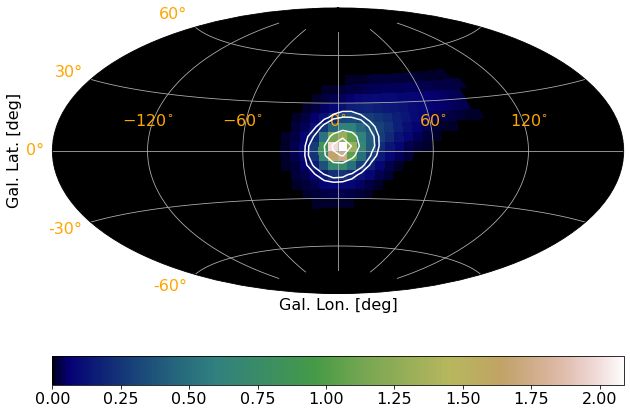

In [213]:
fig, ax = plt.subplots(figsize=(10.24,7.68),subplot_kw={'projection':'aitoff'},nrows=1,ncols=1)

ax.set_xticks(np.array([-120,-60,0,60,120])*deg2rad)
ax.tick_params(axis='x', colors='orange')
ax.set_xticklabels([r'$-120^{\circ}$'+'\n',
                            r'$-60^{\circ}$'+'\n',
                            r'$0^{\circ}$'+'\n',
                            r'$60^{\circ}$'+'\n',
                            r'$120^{\circ}$'+'\n'])
ax.set_yticks(np.array([-60,-30,0,30,60])*deg2rad)
ax.tick_params(axis='y', colors='orange')

ax.set_xlabel('Gal. Lon. [deg]')
ax.set_ylabel('Gal. Lat. [deg]')

# Plot original image
ax.pcolormesh(L_ARRg*deg2rad, B_ARRg*deg2rad, z.reshape(len(x), len(x[0])), cmap=plt.cm.gist_earth)

# Plot contours
num_contours = 2
levels = [np.max(im_fitted)*0.05, np.max(im_fitted)*0.1,
          np.max(im_fitted)*0.5, np.max(im_fitted)*0.8]

#plt.contour(x, y, im_fitted.reshape(len(x), len(x[0])), levels=num_contours, colors='w')

plt.contour(L_ARR*deg2rad, B_ARR*deg2rad, im_fitted.reshape(len(x), len(x[0])), levels = levels, colors='white')

cbar = fig.colorbar(img, orientation='horizontal')
#cbar.ax.set_xlabel(r'Flux [10$^{-2}$ ph cm$^{-2}$ s$^{-1}$]')
    
ax.grid()

In [212]:
print('A:', popt[0])
print('x0 [deg]:', popt[1]*180/np.pi)
print('y0 [deg]:', popt[2]*180/np.pi)
print('sigma_x [deg]:', popt[3]*180/np.pi, '--> FWHM_x [deg]:', 2*np.sqrt(2*np.log(2))*popt[3]*180/np.pi)
print('sigma_y [deg]:', popt[4]*180/np.pi, '--> FWHM_y [deg]:', 2*np.sqrt(2*np.log(2))*popt[4]*180/np.pi)
print('theta [deg]:', popt[5]*180/np.pi)

A: 1.953002471724087
x0 [deg]: -0.7253918640627316
y0 [deg]: -0.5785224964442446
sigma_x [deg]: -9.951949727383349 --> FWHM_x [deg]: -23.435050705182597
sigma_y [deg]: 8.241925894476264 --> FWHM_y [deg]: 19.40825230597234
theta [deg]: 213.101348909868


In [138]:
def get_pixel_flux(image, l, b, num_neighbors=1):
    '''
    Find the flux at a given (l, b) coordinate of interest in the final image.
    Also find the flux in the neighboring pixels.
    
    Parameters:
    image: required, final image to study, array
    l: required, Galactic longitude of interest [deg], float
    b: required, Galactic latitude of interest [deg], float
    num_neighbors: optional, number of neighboring pixels in each direction.
                   default: 1, i.e. 1 pixels on either side of the pixel of 
                            interest for a total of 8 neighboring pixels
    
    Returns:
    Dictionary of pixel boundaries and the flux contained therein. 
    Primary pixel of interest is listed first, followed by neighboring pixels.
    '''
    
    final_image = image*domega
    
    print('Total flux in whole image:', np.sum(final_image), '\n')
    
    for i in range(1, len(l_arrg)):
        l0 = l_arrg[i-1]
        l1 = l_arrg[i]

        for j in range(1, len(b_arrg)):
            b0 = b_arrg[j-1]
            b1 = b_arrg[j]

            if (l0 < l <= l1) and (b0 < b <= b1):

                pixels = {}
                
                pixels[f'l: ({l0}, {l1}), b: ({b0}, {b1})'] = final_image[j-1, i-1]
                
                for n in range(1, num_neighbors+1):
                    
                    # move up n
                    pixels[f'l: ({l_arrg[i-1]}, {l_arrg[i]}), b: ({b_arrg[j-1+n]}, {b_arrg[j+n]})'] = final_image[j-1+n, i-1]
                    
                    # move down n
                    pixels[f'l: ({l_arrg[i-1]}, {l_arrg[i]}), b: ({b_arrg[j-1-n]}, {b_arrg[j-n]})'] = final_image[j-1-n, i-1]
                    
                    # move right n
                    pixels[f'l: ({l_arrg[i-1+n]}, {l_arrg[i+n]}), b: ({b_arrg[j-1]}, {b_arrg[j]})'] = final_image[j-1, i-1+n]
                    
                    # move left n
                    pixels[f'l: ({l_arrg[i-1-n]}, {l_arrg[i-n]}), b: ({b_arrg[j-1]}, {b_arrg[j]})'] = final_image[j-1, i-1-n]
                    
                    # move right n, up n
                    pixels[f'l: ({l_arrg[i-1+n]}, {l_arrg[i+n]}), b: ({b_arrg[j-1+n]}, {b_arrg[j+n]})'] = final_image[j-1+n, i-1+n]
                    
                    # move left n, down n
                    pixels[f'l: ({l_arrg[i-1-n]}, {l_arrg[i-n]}), b: ({b_arrg[j-1-n]}, {b_arrg[j-n]})'] = final_image[j-1-n, i-1-n]

                    # move right n, down n
                    pixels[f'l: ({l_arrg[i-1+n]}, {l_arrg[i+n]}), b: ({b_arrg[j-1-n]}, {b_arrg[j-n]})'] = final_image[j-1-n, i-1+n]
                    
                    # move left n, up n
                    pixels[f'l: ({l_arrg[i-1-n]}, {l_arrg[i-n]}), b: ({b_arrg[j-1+n]}, {b_arrg[j+n]})'] = final_image[j-1+n, i-1-n]
                
    
                return pixels

In [139]:
final_idx = iterations-1
final_image = np.roll(map_iterations[:,:,final_idx], axis=1, shift=0)

# get total sum with masking poor exposure
#map_iterations_nan_to_zero = np.nan_to_num(map_iterations_nan)
#final_image = np.roll(map_iterations_nan_to_zero[:,:,final_idx],axis=1,shift=0)

pixels = get_pixel_flux(final_image, l=-3, b=-3, num_neighbors=3)

Total flux in whole image: 0.013785271153439471 



In [141]:
np.sum(final_image*domega)

0.013785271153439471

In [212]:
#pixels

In [213]:
sort = dict(sorted(pixels.items(), key=lambda item:item[1], reverse=True))  
    
for k, v in sort.items():
    print(k, v)

l: (12.0, 18.0), b: (12.0, 18.0) 8.749196366156355e-14
l: (12.0, 18.0), b: (-6.0, 0.0) 3.971812210254066e-14
l: (6.0, 12.0), b: (6.0, 12.0) 2.350129772419959e-14
l: (6.0, 12.0), b: (-6.0, 0.0) 9.668415112665398e-15
l: (0.0, 6.0), b: (0.0, 6.0) 3.062890725793341e-15
l: (0.0, 6.0), b: (-6.0, 0.0) 2.5453482199130704e-15
l: (0.0, 6.0), b: (-12.0, -6.0) 1.4080059073788546e-15
l: (12.0, 18.0), b: (-24.0, -18.0) 1.1867194225259358e-15
l: (6.0, 12.0), b: (-18.0, -12.0) 2.4600095559080833e-16
l: (-6.0, 0.0), b: (0.0, 6.0) 1.3215890332893096e-16
l: (-6.0, 0.0), b: (12.0, 18.0) 7.536852429834181e-17
l: (-6.0, 0.0), b: (-6.0, 0.0) 6.136488798361591e-17
l: (-6.0, 0.0), b: (6.0, 12.0) 5.2596699601638675e-17
l: (-6.0, 0.0), b: (-12.0, -6.0) 3.9278535721053404e-17
l: (-6.0, 0.0), b: (-24.0, -18.0) 2.1715710732202808e-17
l: (-6.0, 0.0), b: (-18.0, -12.0) 7.080120342095435e-18
l: (-12.0, -6.0), b: (0.0, 6.0) 7.279818257980175e-19
l: (-18.0, -12.0), b: (6.0, 12.0) 4.645277091639941e-19
l: (-24.0, -18.0),

In [214]:
fluxes = list(pixels.values())

In [215]:
np.sum(fluxes)

1.6922072267375175e-13

In [216]:
# max flux in a single pixel of the whole image
max_flux = max(np.ravel(final_image*domega))
print(max_flux)

l_max_idx = np.where(final_image*domega == max_flux)[1][0]
b_max_idx = np.where(final_image*domega == max_flux)[0][0]

0.018132923041524012


In [702]:
l_max = l_arrg[l_max_idx]
l_max

12.0

In [703]:
b_max = b_arrg[b_max_idx]
b_max

0.0

In [704]:
# print top 30 pixels with highest flux
for i in range(30):
    print(np.sort(np.ravel(final_image*domega))[::-1][i])

3.071851339130231e-05
3.0100842677613164e-05
2.9443463649522603e-05
2.9256312516693817e-05
2.905006591660493e-05
2.84553317270758e-05
2.8428918714155197e-05
2.762163185579939e-05
2.6975931608789246e-05
2.6948873124778878e-05
2.6557911969552037e-05
2.6478199234377913e-05
2.5941625288448574e-05
2.5879400636939135e-05
2.5722258265188365e-05
2.5514826607799472e-05
2.5375720490802355e-05
2.5362577062790228e-05
2.529360301914753e-05
2.5101097590007296e-05
2.4830001890566548e-05
2.4486225041256276e-05
2.312629988797791e-05
2.2031529459544376e-05
2.1677306341804e-05
2.1655512195367068e-05
2.1473679507327345e-05
2.1451260550708872e-05
2.142169559661491e-05
2.1127249820437357e-05
